In [45]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os, argparse
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

In [ ]:
# load kallisto bus output dataset
# demonstrate how cell-gene mat is generated
# dont run this

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('./count_out/output_unfiltered.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        # Here shows how umi collision collapse in kallisto
        # This collapse methods is different from the description in the paper which result in more detected gene
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]

In [ ]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s

## Check barcode-gene distribution

In [ ]:
threshold = 0 # this filters the data by gene count
bcv = [x for b,x in barcode_hist.items() if x > 500] 
_ = plt.hist(bcv,bins=40, log=True)
plt.rcParams["figure.figsize"] = [9,6]
plt.xlabel("Number of gene counts")
plt.ylabel("Number of barcodes")
print(len(bcv))

In [47]:
import scanpy as sc
import anndata
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io
import seaborn as sns

## Import cell-gene count matrix

In [158]:
adata_38 = anndata.read("./count_out_SRR7722938/counts_unfiltered/adata.h5ad")
adata_42 = anndata.read("./count_out_SRR7722942/counts_unfiltered/adata.h5ad")
adatas = [adata_38, adata_42]
samples = ['SRR7722938', 'SRR7722942']

In [159]:
adatas

[AnnData object with n_obs × n_vars = 266736 × 59412,
 AnnData object with n_obs × n_vars = 147145 × 59412]

## Unfiltered cell-gene count matrix QC Check

In [160]:
# add mito label for later qc func
for adata in adatas:
    adata.var['mito'] = adata.var.index.str.startswith('MT-')

In [161]:
qc_unfiltereds = [sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=False) for adata in adatas]

In [52]:
qc_unfiltereds[0][0]

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
barcode                                                                      
AAACCTGAGAAACCAT                  1                 0.693147      1.000000   
AAACCTGAGAAACCGC                  1                 0.693147      1.000000   
AAACCTGAGAAAGTGG                  1                 0.693147      1.000000   
AAACCTGAGAACTCGG                  1                 0.693147      1.000000   
AAACCTGAGAAGAAGC                 55                 4.025352     53.999999   
...                             ...                      ...           ...   
TTTGTCATCTTGTTTG                  1                 0.693147      1.000000   
TTTGTCATCTTTACAC                 61                 4.127134     46.999996   
TTTGTCATCTTTACGT                 60                 4.110874     52.999997   
TTTGTCATCTTTAGGG                  2                 1.098612      2.000000   
TTTGTCATCTTTAGTC                  4                 1.609438      4.000000   

                  log1p_total_counts  pct_counts_in_top_50_genes  \
barcode                                                            
AAACCTGAGAAACCAT            0.693147                  100.000000   
AAACCTGAGAAACCGC            0.693147                  100.000000   
AAACCTGAGAAAGTGG            0.693147                  100.000000   
AAACCTGAGAACTCGG            0.693147                  100.000000   
AAACCTGAGAAGAAGC            4.007333                   96.296298   
...                              ...                         ...   
TTTGTCATCTTGTTTG            0.693147                  100.000000   
TTTGTCATCTTTACAC            3.871201                   93.617023   
TTTGTCATCTTTACGT            3.988984                   94.339626   
TTTGTCATCTTTAGGG            1.098612                  100.000000   
TTTGTCATCTTTAGTC            1.609438                  100.000000   

                  pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
barcode                                                                      
AAACCTGAGAAACCAT                        100.0                        100.0   
AAACCTGAGAAACCGC                        100.0                        100.0   
AAACCTGAGAAAGTGG                        100.0                        100.0   
AAACCTGAGAACTCGG                        100.0                        100.0   
AAACCTGAGAAGAAGC                        100.0                        100.0   
...                                       ...                          ...   
TTTGTCATCTTGTTTG                        100.0                        100.0   
TTTGTCATCTTTACAC                        100.0                        100.0   
TTTGTCATCTTTACGT                        100.0                        100.0   
TTTGTCATCTTTAGGG                        100.0                        100.0   
TTTGTCATCTTTAGTC                        100.0                        100.0   

                  pct_counts_in_top_500_genes  total_counts_mito  \
barcode                                                            
AAACCTGAGAAACCAT                        100.0                0.0   
AAACCTGAGAAACCGC                        100.0                0.0   
AAACCTGAGAAAGTGG                        100.0                0.0   
AAACCTGAGAACTCGG                        100.0                0.0   
AAACCTGAGAAGAAGC                        100.0                7.0   
...                                       ...                ...   
TTTGTCATCTTGTTTG                        100.0                0.0   
TTTGTCATCTTTACAC                        100.0                1.0   
TTTGTCATCTTTACGT                        100.0                4.0   
TTTGTCATCTTTAGGG                        100.0                0.0   
TTTGTCATCTTTAGTC                        100.0                0.0   

                  log1p_total_counts_mito  pct_counts_mito  
barcode                                                     
AAACCTGAGAAACCAT                 0.000000         0.000000  
AAACCTGAGAAACCGC                 0.

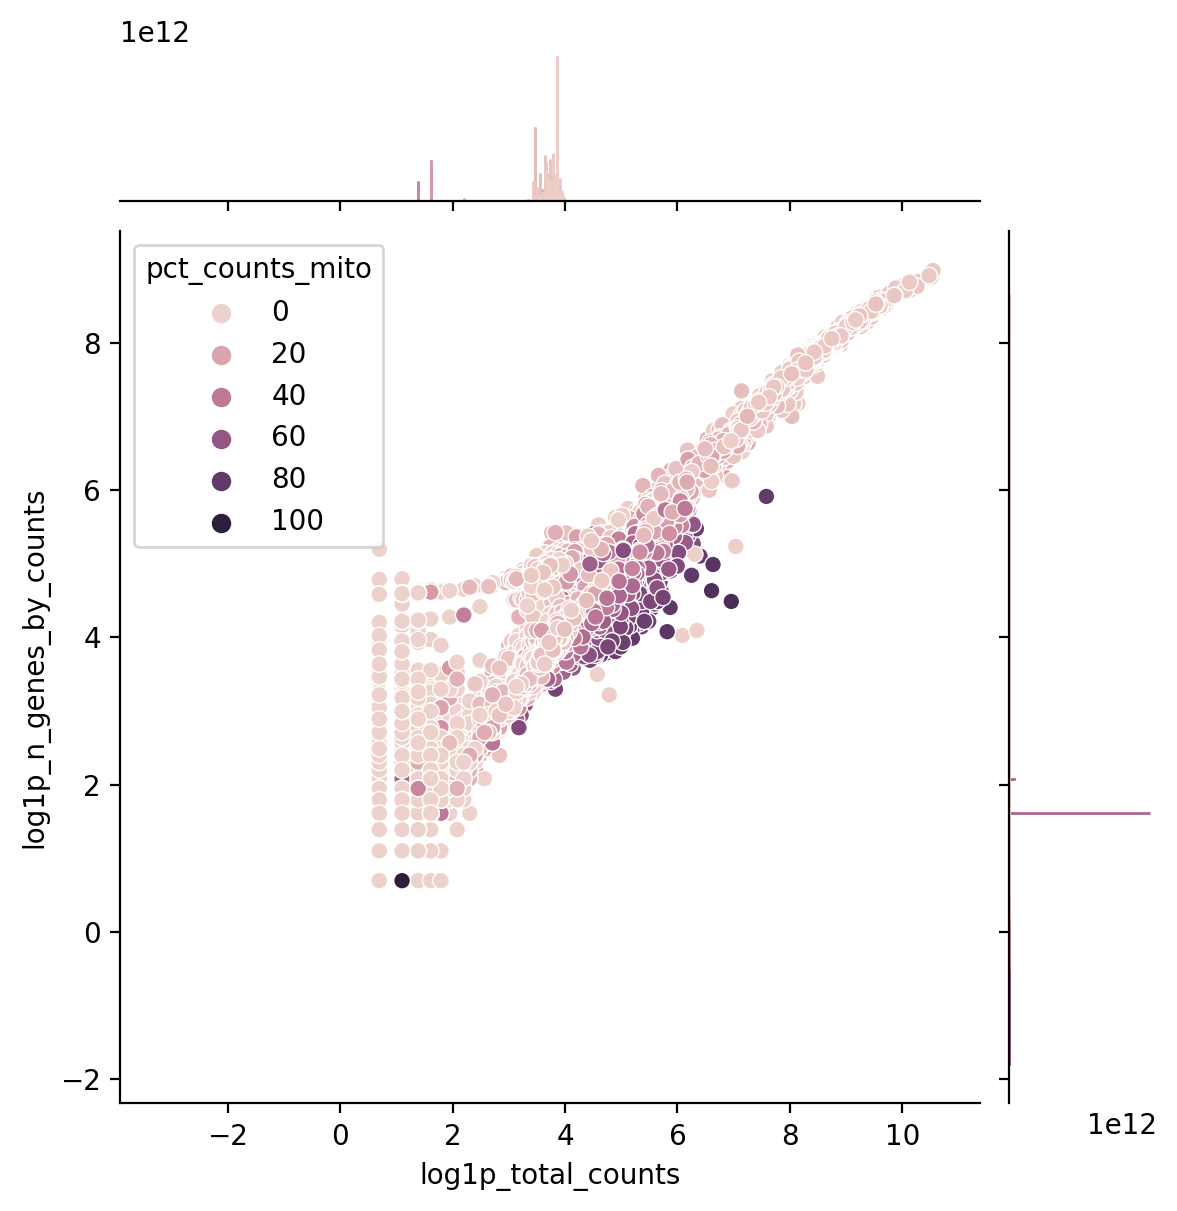

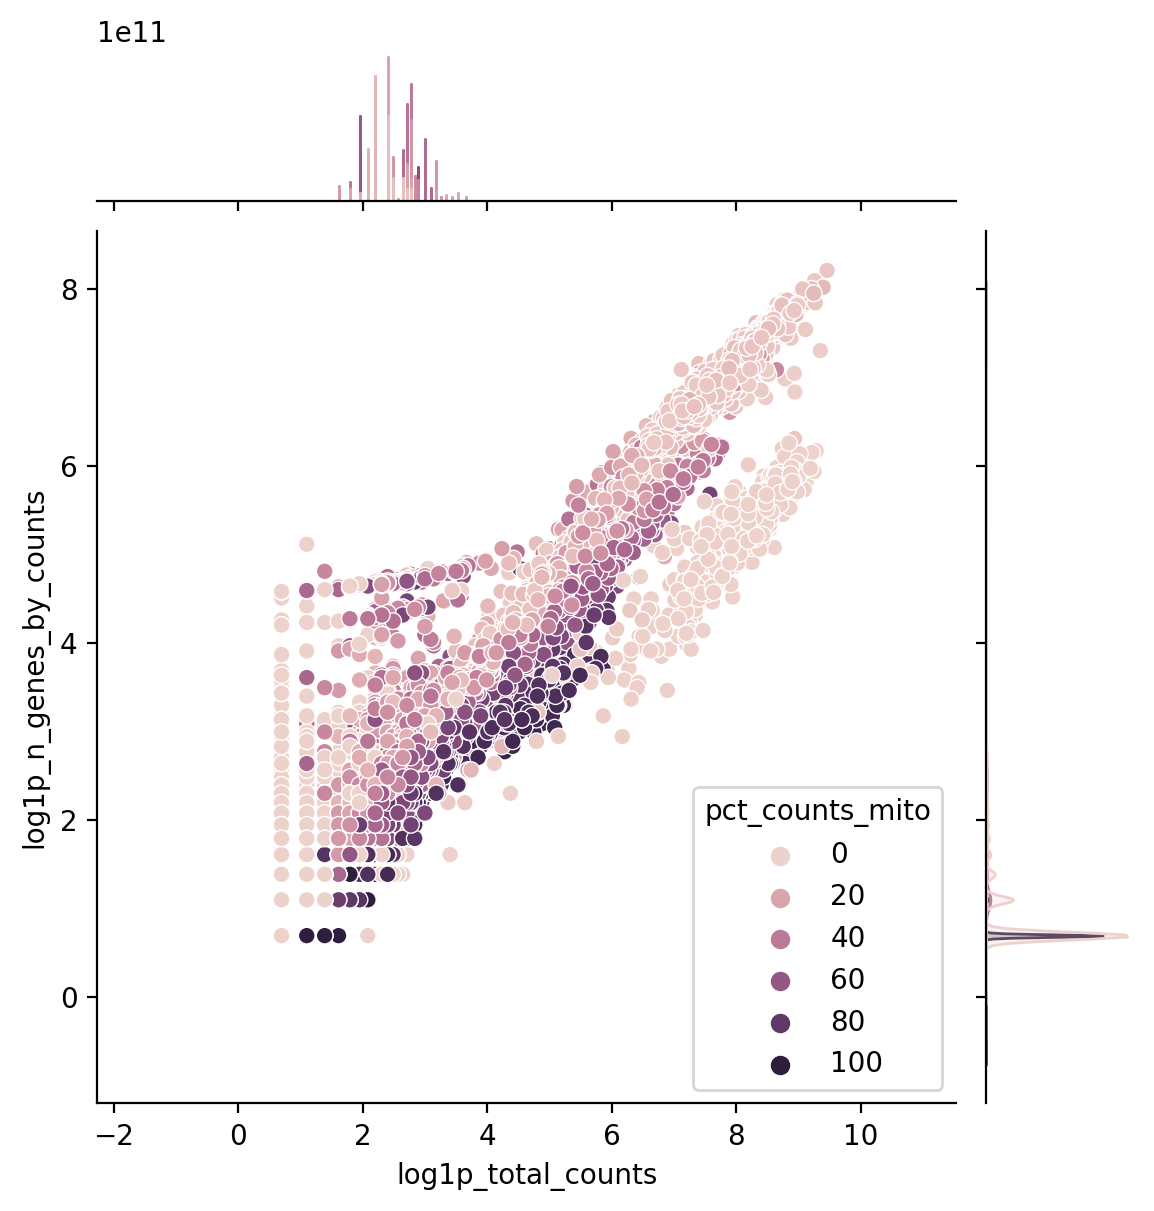

In [53]:
for unfiltered in qc_unfiltereds:
    sns.jointplot(
        data=unfiltered[0],
        x='log1p_total_counts',
        y='log1p_n_genes_by_counts',
        hue='pct_counts_mito'
    )

## Check PCA plot

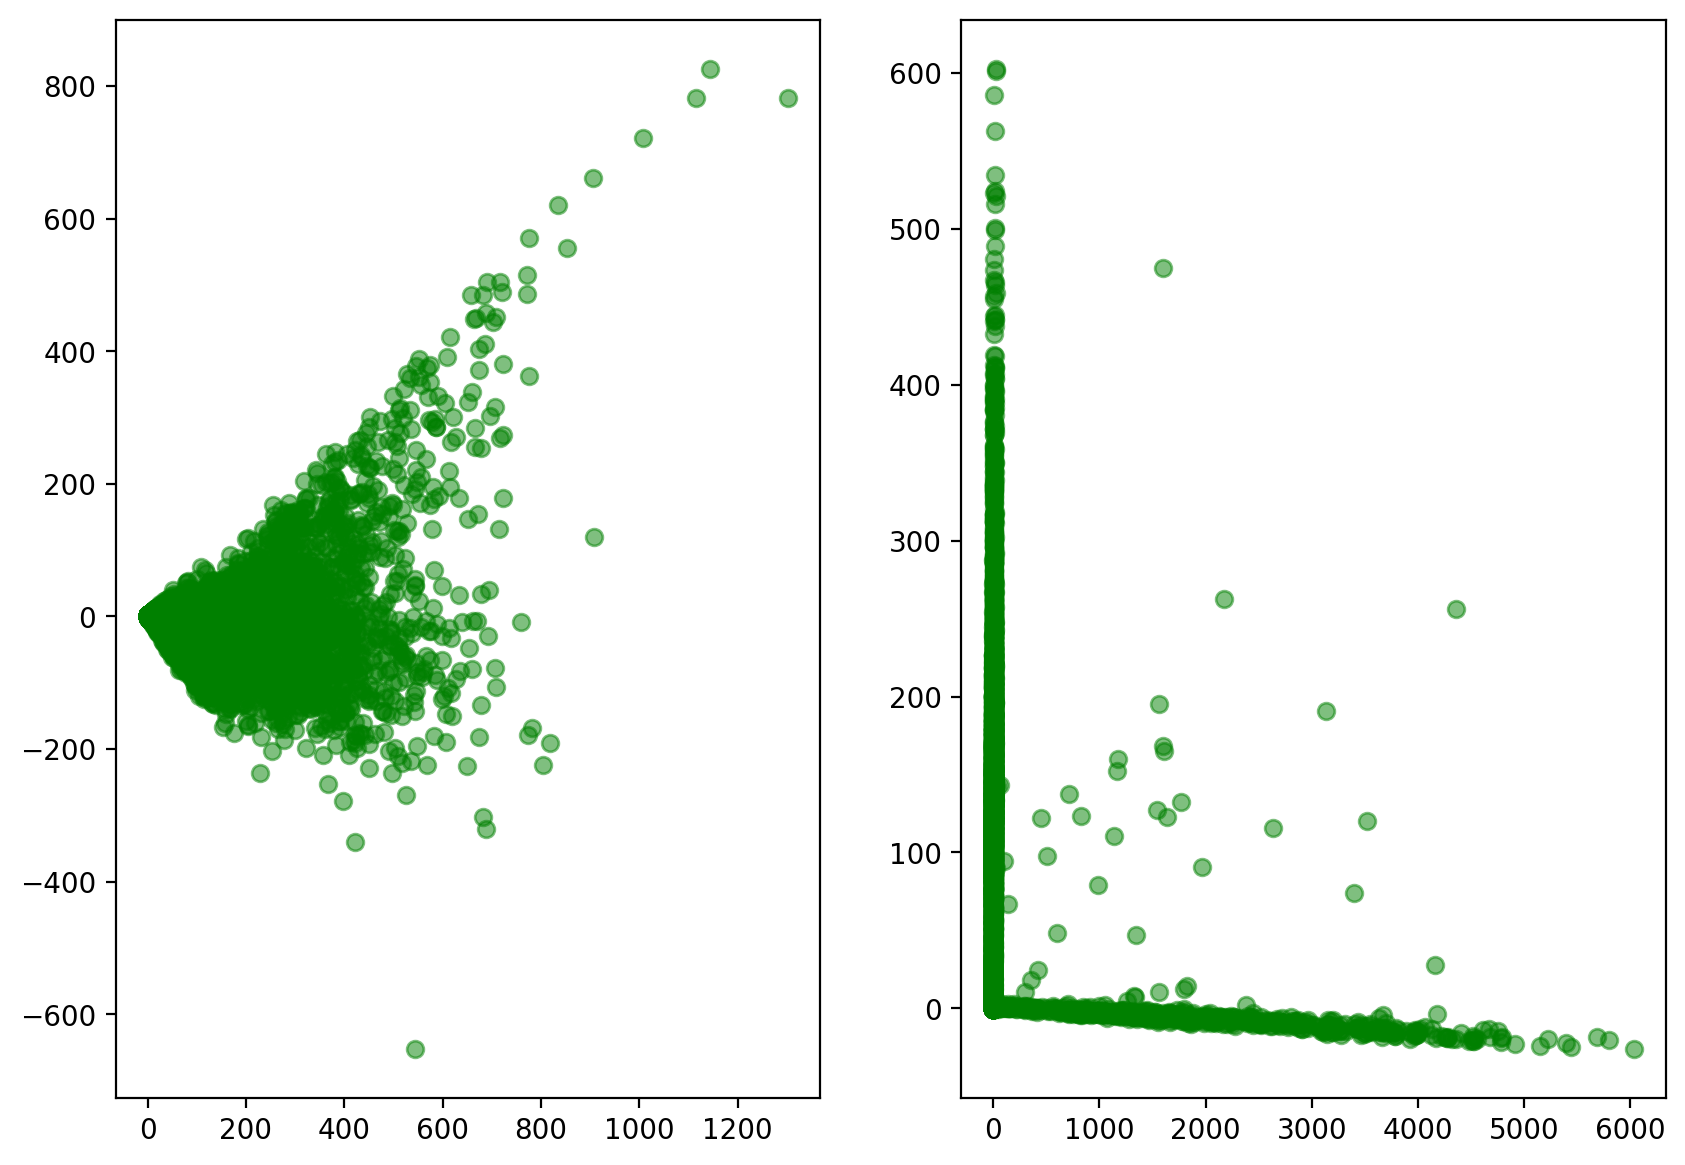

In [54]:
# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

for idx in range(len(adatas)):
    tsvd = TruncatedSVD(n_components=2)
    tsvd.fit(adatas[idx].X)
    X = tsvd.transform(adatas[idx].X)
    ax[idx].scatter(X[:,0], X[:,1], alpha=0.5, c="green")



plt.show()

## Knee point

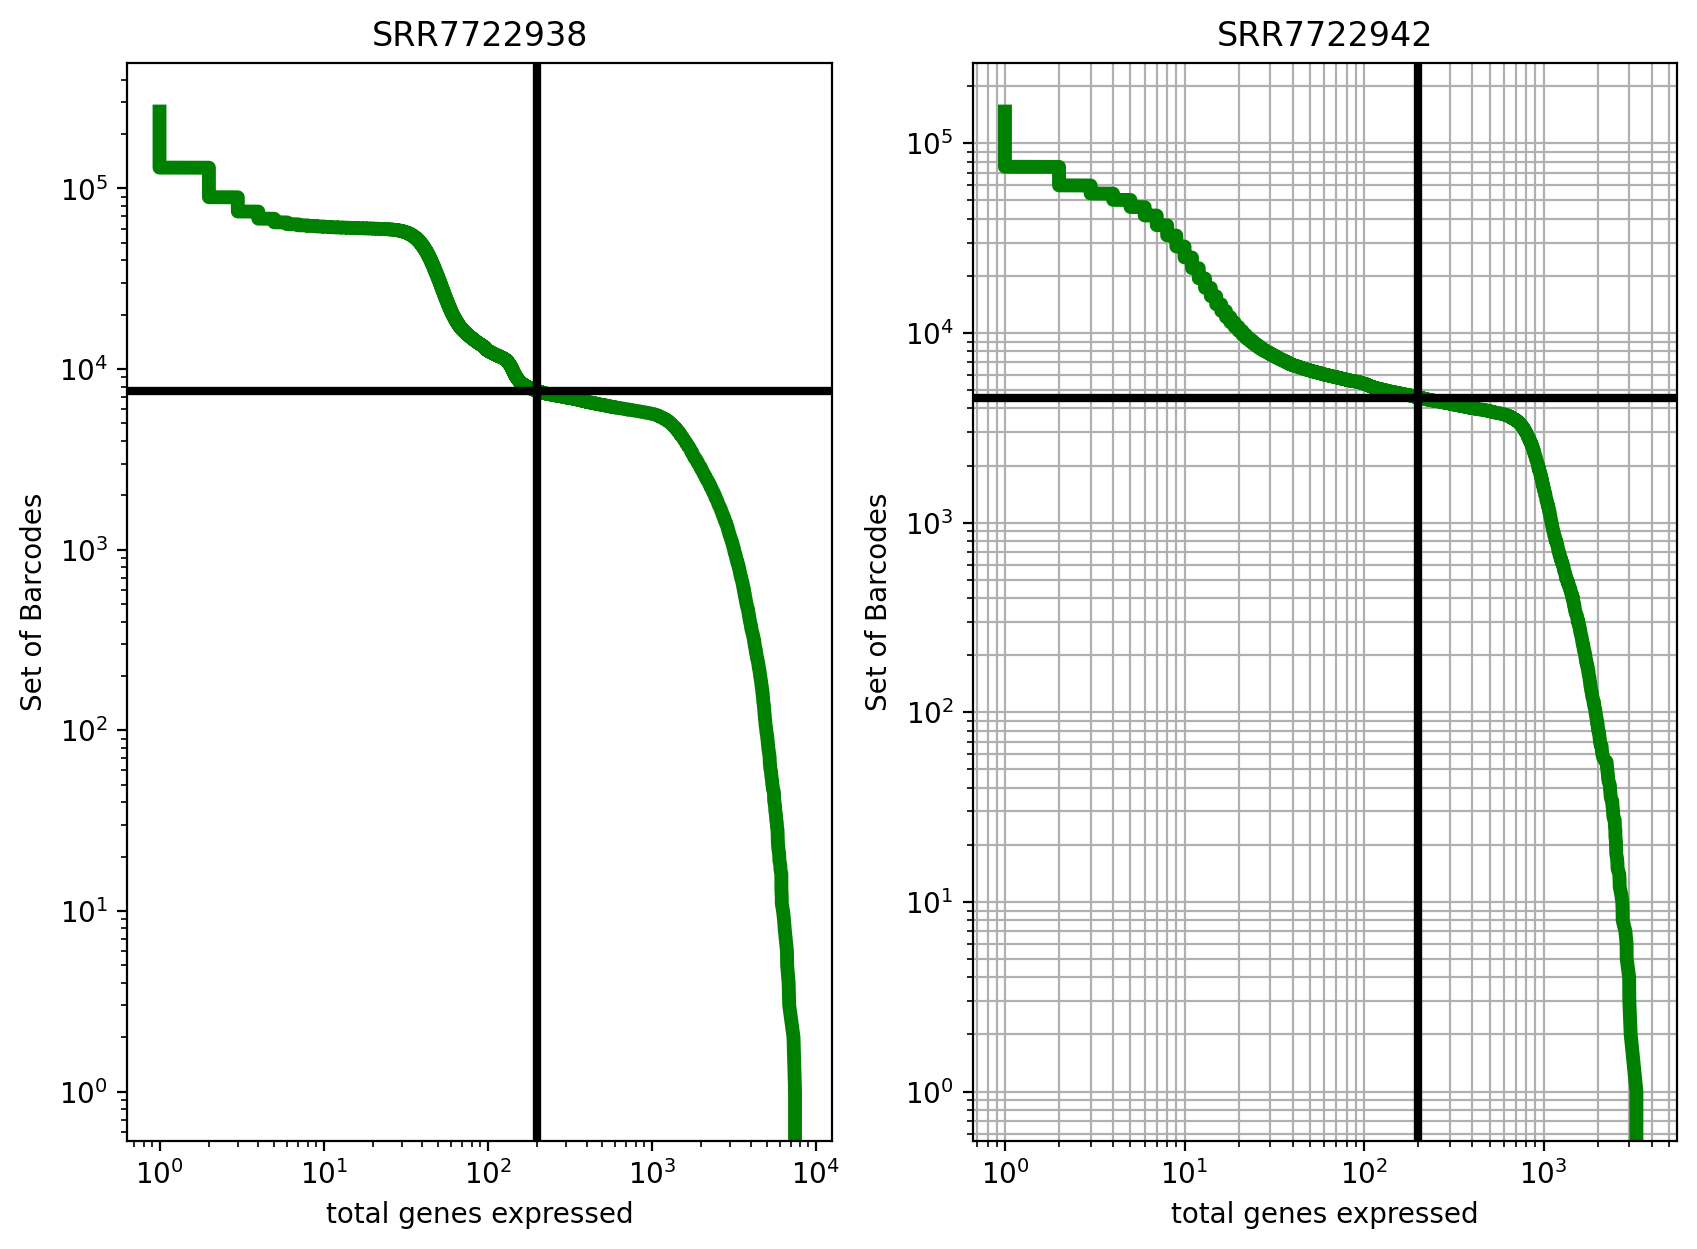

In [162]:
# { run: "auto", vertical-output: true }
# The idea is that "real" cells have a certain number of UMI counts 
# and that a threshold on the UMI counts filters those cells.
cutoff =  200

fig, ax = plt.subplots(1, 2, figsize=(10, 7))

cell_filters = []
knees = []
for i in range(len(adatas)):
    # option 1 (describe in tutorial)
    # desc sorted total gene expressed per cell
#     knee = np.sort((np.array(adatas[i].X.sum(axis=1))).flatten())[::-1]
    knee= np.sort((np.array(np.sum(adatas[i].X > 0, axis=1))).flatten())[::-1]
    knees.append(knee)
    # optioin 2 (describe in paper)
    # we ordered our digital expression matrix by the *total number of transcripts(umi count)* per
    # cell barcode, and plotted the cumulative fraction of all transcripts in the matrix for each successively
    # smaller cell barcode.
    # knee= np.sort((np.array(np.sum(adata.X > 0, axis=1))).flatten())[::-1]

    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]
    cell_filters.append(num_cells)

    # option 1
    ax[i].loglog(knee, cell_set, linewidth=5, color="g")
    ax[i].axvline(x=cutoff, linewidth=3, color="k")
    ax[i].axhline(y=num_cells, linewidth=3, color="k")
    ax[i].set_xlabel("total genes expressed")
    ax[i].set_ylabel("Set of Barcodes")
    ax[i].set_title(samples[i])


plt.grid(True, which="both")
plt.show()

In [163]:
for i in range(len(samples)):
    print(f"In {samples[i]}: {cell_filters[i]:,.0f} cells passed the {cutoff} UMI threshold")
# print(f"{num_cells_2:,.0f} cells passed the {cutoff} UMI threshold")

In SRR7722938: 7,565 cells passed the 200 UMI threshold
In SRR7722942: 4,569 cells passed the 200 UMI threshold


## Filter data

#### Cell filter
    1. minimum 200 genes expressed in each cell
    2. maximum 2500 genes expressed in each cell
    3. minimum count is calaulated is calc by knee point
### gene filter
    1. gene must be expressed in at least 3 cells
    2. at least 1 umi count contribute to the expressed gene

In [164]:
# empty droplets
adatas

[AnnData object with n_obs × n_vars = 266736 × 59412
     var: 'mito',
 AnnData object with n_obs × n_vars = 147145 × 59412
     var: 'mito']

In [165]:
# mito content < .5

# Filter the cells according to the threshold determined from the knee plot
for i in range(len(adatas)):
    adatas[i] = adatas[i][qc_unfiltereds[i][0].pct_counts_mito < 5, :]
    sc.pp.filter_cells(adatas[i], min_genes=200)
    sc.pp.filter_cells(adatas[i], max_genes = 2500)
    sc.pp.filter_cells(adatas[i], min_counts=knees[i][cell_filters[i]])
    sc.pp.filter_genes(adatas[i], min_cells=3)
    sc.pp.filter_genes(adatas[i], min_counts=1)
    
    

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [166]:
adatas

[AnnData object with n_obs × n_vars = 3171 × 24612
     obs: 'n_genes', 'n_counts'
     var: 'mito', 'n_cells', 'n_counts',
 AnnData object with n_obs × n_vars = 1413 × 18661
     obs: 'n_genes', 'n_counts'
     var: 'mito', 'n_cells', 'n_counts']

## QC check after /w filtered matrix

In [167]:
qc_filtereds = [sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=False) for adata in adatas]

In [168]:
for adata, qc in zip(adatas, qc_filtereds):
    adata.obs['pct_counts_mito'] = qc[0]['pct_counts_mito']

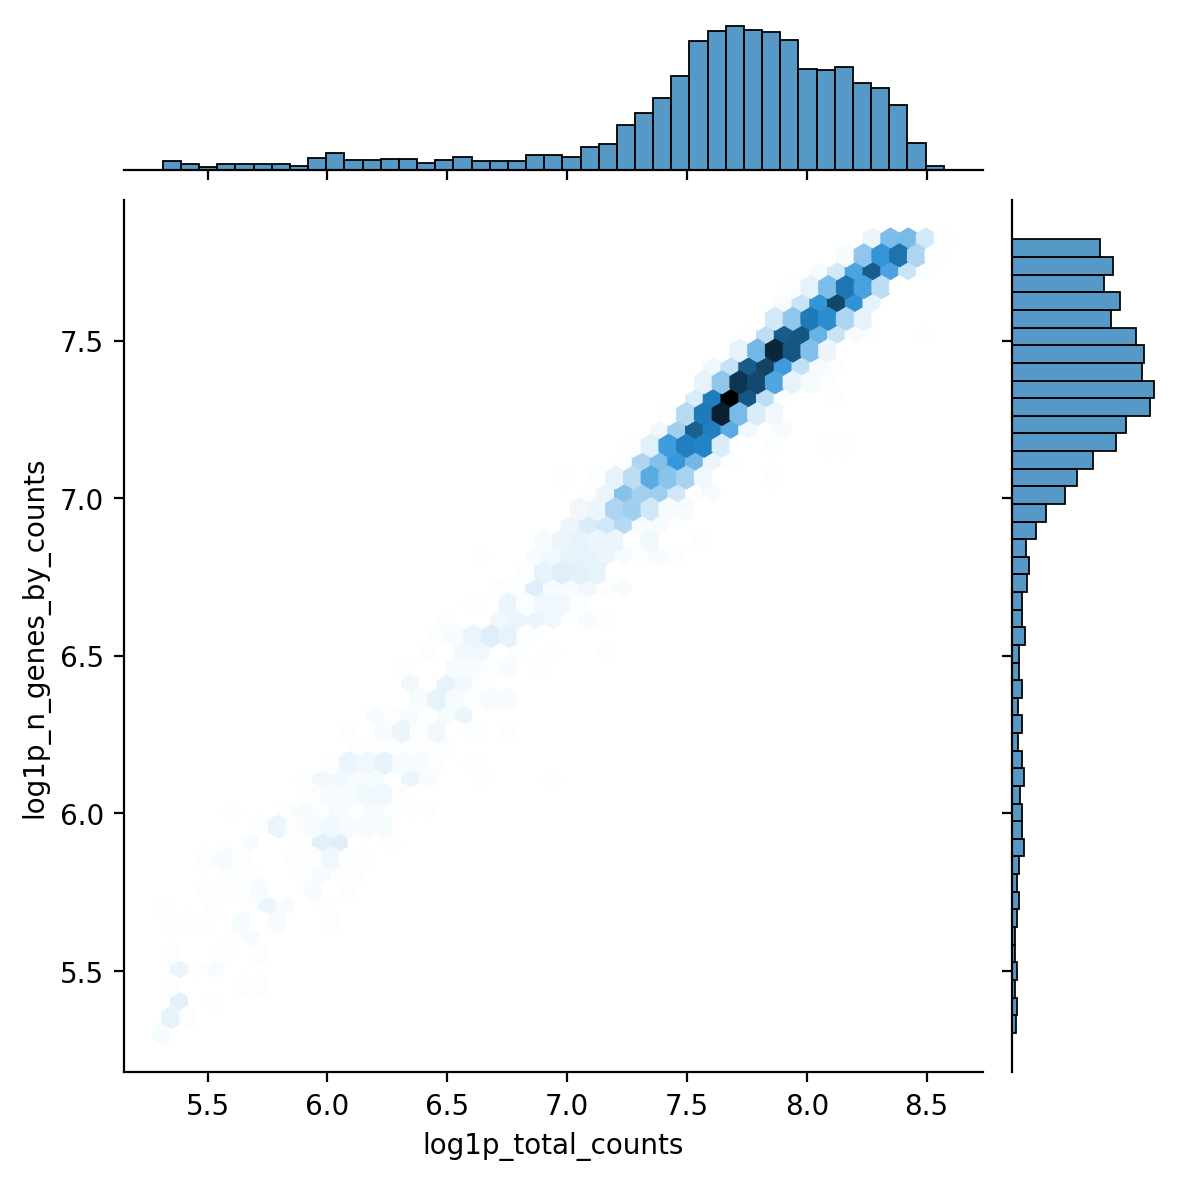

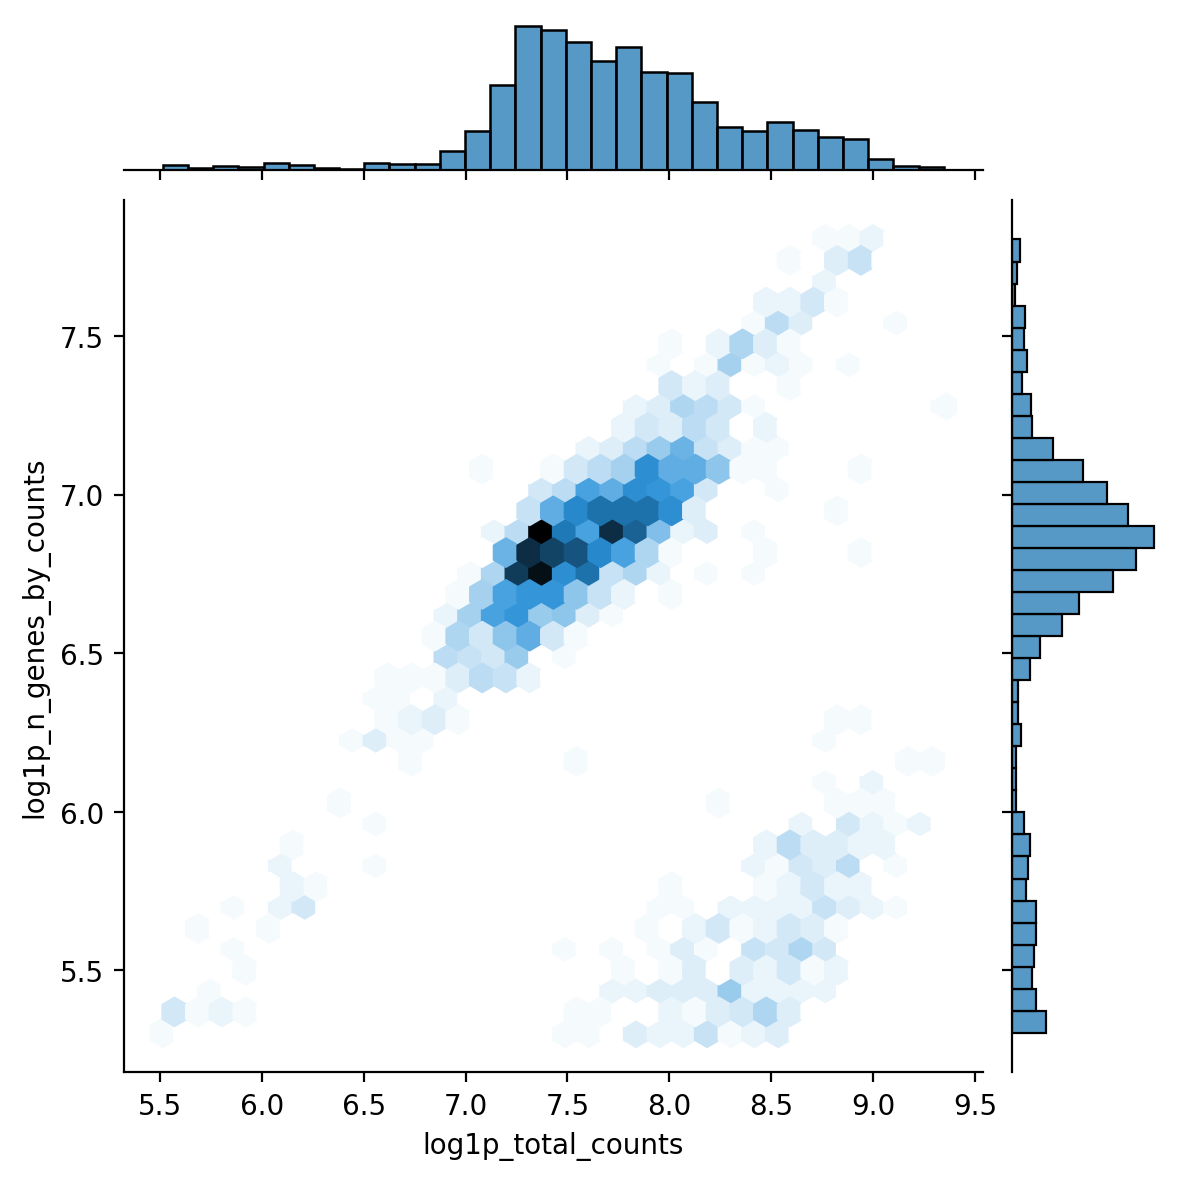

In [169]:
for qc_filtered in qc_filtereds:
    sns.jointplot(
        data=qc_filtered[0],
        x='log1p_total_counts',
        y='log1p_n_genes_by_counts',
        kind='hex'
    )

<Axes: xlabel='pct_counts_mito', ylabel='Count'>

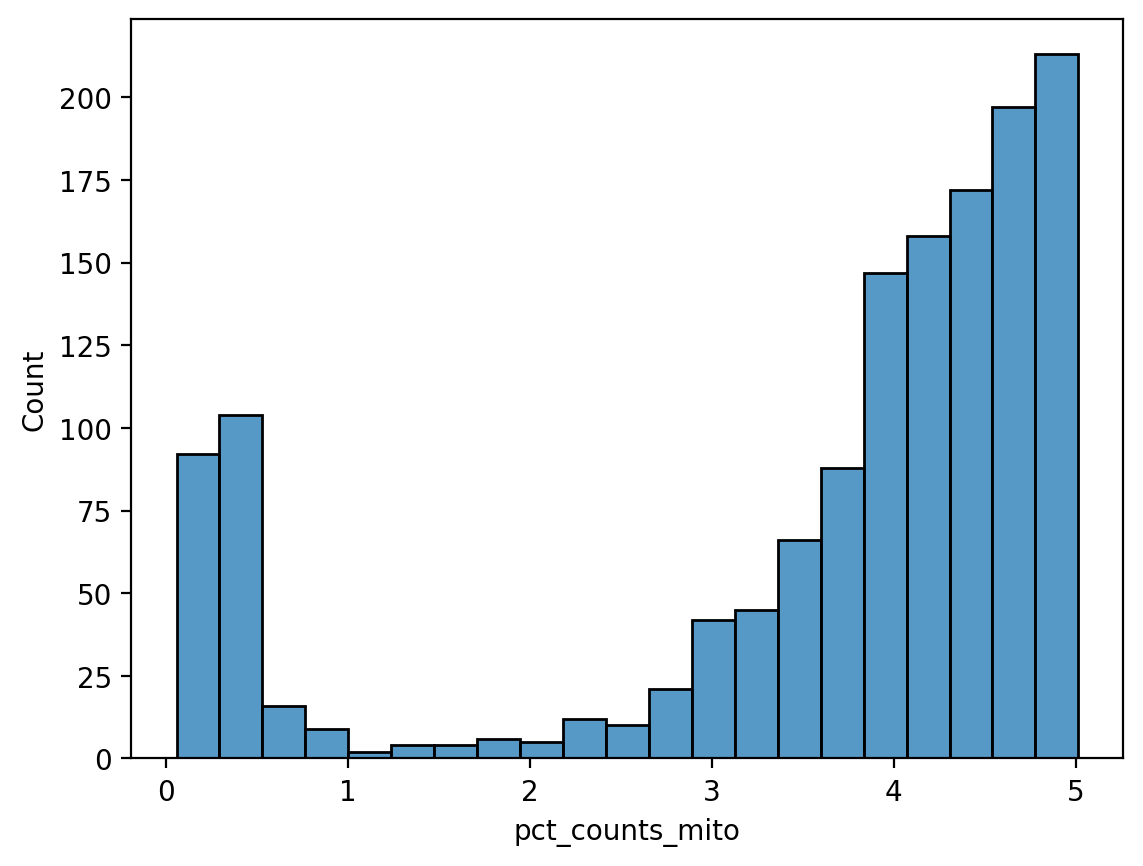

In [170]:
# mitochondria protein gene check
sns.histplot(qc_filtered[0]["pct_counts_mito"])

In [171]:
qc_filtereds[0][0]

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
barcode                                                                      
AAACCTGCAGTTCATG               2030                 7.616284   3345.500083   
AAACCTGGTATTCGTG               1499                 7.313220   2133.000003   
AAACCTGTCGAACTGT               1766                 7.477038   2984.857053   
AAACGGGAGTGACTCT               2096                 7.648263   3419.999918   
AAACGGGGTACTTGAC               1329                 7.192934   1919.499990   
...                             ...                      ...           ...   
TTTGGTTCAGATGGGT               2065                 7.633370   3447.999967   
TTTGGTTGTAAGGGAA               1642                 7.404279   2351.933302   
TTTGGTTGTTCCAACA               2064                 7.632886   3965.464194   
TTTGTCAGTTCAACCA               1433                 7.268223   2064.000027   
TTTGTCATCATAAAGG               1330                 7.193686   1706.964240   

                  log1p_total_counts  pct_counts_in_top_50_genes  \
barcode                                                            
AAACCTGCAGTTCATG            8.115670                   24.192697   
AAACCTGGTATTCGTG            7.665753                   23.905297   
AAACCTGTCGAACTGT            8.001642                   26.380140   
AAACGGGAGTGACTCT            8.137688                   22.429337   
AAACGGGGTACTTGAC            7.560341                   28.049837   
...                              ...                         ...   
TTTGGTTCAGATGGGT            8.145840                   24.472653   
TTTGGTTGTAAGGGAA            7.763418                   22.734218   
TTTGGTTGTTCCAACA            8.285630                   32.131588   
TTTGTCAGTTCAACCA            7.632886                   24.644703   
TTTGTCATCATAAAGG            7.443057                   25.032906   

                  pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
barcode                                                                      
AAACCTGCAGTTCATG                    33.303252                    44.012971   
AAACCTGGTATTCGTG                    33.041285                    44.670256   
AAACCTGTCGAACTGT                    37.105947                    48.474219   
AAACGGGAGTGACTCT                    32.240253                    43.563260   
AAACGGGGTACTTGAC                    40.229225                    52.674513   
...                                       ...                          ...   
TTTGGTTCAGATGGGT                    34.406063                    45.074496   
TTTGGTTGTAAGGGAA                    32.325618                    44.389179   
TTTGGTTGTTCCAACA                    42.488928                    53.114058   
TTTGTCAGTTCAACCA                    34.959137                    46.721202   
TTTGTCATCATAAAGG                    35.268332                    48.756215   

                  pct_counts_in_top_500_genes  total_counts_mito  \
barcode                                                            
AAACCTGCAGTTCATG                    62.910636          163.83330   
AAACCTGGTATTCGTG                    63.250033           55.83333   
AAACCTGTCGAACTGT                    64.949157           58.50000   
AAACGGGAGTGACTCT                    62.220329          127.50000   
AAACGGGGTACTTGAC                    70.826256           90.00000   
...                                       ...                ...   
TTTGGTTCAGATGGGT                    62.341011          104.83330   
TTTGGTTGTAAGGGAA                    63.117339           97.50000   
TTTGGTTGTTCCAACA                    69.215380          169.50000   
TTTGTCAGTTCAACCA                    65.834336           74.00000   
TTTGTCATCATAAAGG                    68.977714           60.00000   

                  log1p_total_counts_mito  pct_counts_mito  
barcode                                                     
AAACCTGCAGTTCATG                 5.104935         4.897124  
AAACCTGGTATTCGTG                 4.

In [64]:
qc_filtereds[1][0]

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
barcode                                                                      
AAACGGGCATCCCACT                287                 5.662960   6443.999999   
AAACGGGCATGCCTAA               1323                 7.188413   2542.687335   
AAAGATGGTGTCGCTG                213                 5.365976   4900.999996   
AAAGCAACAATGCCAT               1162                 7.058758   2763.361541   
AAAGCAACATTGAGCT               1189                 7.081709   1877.799940   
...                             ...                      ...           ...   
TTTGGTTTCTCGGACG                265                 5.583496   4783.999997   
TTTGTCAAGCAGATCG                291                 5.676754   4826.999997   
TTTGTCAAGCGAGAAA                308                 5.733341   6829.999992   
TTTGTCAAGGAATTAC                337                 5.823046   7316.000009   
TTTGTCATCATTGCGA               1029                 6.937314   2677.275914   

                  log1p_total_counts  pct_counts_in_top_50_genes  \
barcode                                                            
AAACGGGCATCCCACT            8.771060                   96.880819   
AAACGGGCATGCCTAA            7.841370                   35.484106   
AAAGATGGTGTCGCTG            8.497399                   96.865800   
AAAGCAACAATGCCAT            7.924565                   42.549163   
AAAGCAACATTGAGCT            7.538389                   31.474775   
...                              ...                         ...   
TTTGGTTTCTCGGACG            8.473241                   96.117266   
TTTGTCAAGCAGATCG            8.482188                   95.790790   
TTTGTCAAGCGAGAAA            8.829226                   96.372621   
TTTGTCAAGGAATTAC            8.897956                   96.131082   
TTTGTCATCATTGCGA            7.892929                   48.220028   

                  pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
barcode                                                                      
AAACGGGCATCCCACT                    97.759334                    99.311165   
AAACGGGCATGCCTAA                    48.623092                    61.194734   
AAAGATGGTGTCGCTG                    98.178457                    99.941557   
AAAGCAACAATGCCAT                    58.687004                    71.046993   
AAAGCAACATTGAGCT                    45.429491                    58.473673   
...                                       ...                          ...   
TTTGGTTTCTCGGACG                    97.350544                    99.440845   
TTTGTCAAGCAGATCG                    97.087316                    99.158997   
TTTGTCAAGCGAGAAA                    97.490727                    98.954856   
TTTGTCAAGGAATTAC                    97.221615                    98.588482   
TTTGTCATCATTGCGA                    64.727327                    76.081350   

                  pct_counts_in_top_500_genes  total_counts_mito  \
barcode                                                            
AAACGGGCATCCCACT                   100.000000               10.5   
AAACGGGCATGCCTAA                    77.298347              116.0   
AAAGATGGTGTCGCTG                   100.000000               17.0   
AAAGCAACAATGCCAT                    84.283575              102.0   
AAAGCAACATTGAGCT                    77.113028               80.5   
...                                       ...                ...   
TTTGGTTTCTCGGACG                   100.000000               21.5   
TTTGTCAAGCAGATCG                   100.000000               12.5   
TTTGTCAAGCGAGAAA                   100.000000               12.5   
TTTGTCAAGGAATTAC                   100.000000               28.5   
TTTGTCATCATTGCGA                    88.972860               94.5   

                  log1p_total_counts_mito  pct_counts_mito  
barcode                                                     
AAACGGGCATCCCACT                 2.442347         0.162942  
AAACGGGCATGCCTAA                 4.

In [65]:
qc_filtereds[0][1]

n_cells_by_counts  mean_counts  log1p_mean_counts  \
gene_name                                                        
WASH7P                      21     0.001504           0.001503   
MIR1302-2HG                  4     0.000420           0.000420   
AL627309.1                  13     0.001997           0.001995   
CICP27                      17     0.004625           0.004615   
AL627309.6                   6     0.000739           0.000739   
...                        ...          ...                ...   
RNA5-8SN5                   54     0.002208           0.002205   
AL354822.1                  37     0.010757           0.010700   
AC023491.2                   8     0.000424           0.000423   
AC004556.3                 764     0.163828           0.151715   
AC240274.1                  55     0.007851           0.007820   

             pct_dropout_by_counts  total_counts  log1p_total_counts  
gene_name                                                             
WASH7P                   99.337748      4.769047            1.752507  
MIR1302-2HG              99.873857      1.333332            0.847297  
AL627309.1               99.590035      6.333332            1.992430  
CICP27                   99.463892     14.666666            2.751535  
AL627309.6               99.810785      2.342856            1.206826  
...                            ...           ...                 ...  
RNA5-8SN5                98.297067      7.000000            2.079442  
AL354822.1               98.833176     34.111111            3.558518  
AC023491.2               99.747714      1.343101            0.851475  
AC004556.3               75.906654    519.500000            6.254790  
AC240274.1               98.265531     24.895687            3.254076  

[24612 rows x 6 columns]

In [66]:
qc_filtereds[1][1]

n_cells_by_counts  mean_counts  log1p_mean_counts  \
gene_name                                                       
WASH7P                     11     0.001881           0.001880   
AL627309.1                  5     0.001499           0.001498   
AL627309.5                 29     0.009142           0.009100   
WASH9P                     13     0.002223           0.002221   
AP006222.1                 23     0.006286           0.006266   
...                       ...          ...                ...   
AC007325.4                 29     0.007726           0.007696   
RNA5-8SN5                  19     0.001681           0.001679   
AC023491.2                  4     0.000786           0.000786   
AC004556.3                191     0.088464           0.084768   
AC240274.1                 20     0.003539           0.003533   

            pct_dropout_by_counts  total_counts  log1p_total_counts  
gene_name                                                            
WASH7P                  99.221515      2.658332            1.297007  
AL627309.1              99.646143      2.117816            1.137133  
AL627309.5              97.947629     12.917412            2.633141  
WASH9P                  99.079972      3.141666            1.421098  
AP006222.1              98.372258      8.882135            2.290729  
...                           ...           ...                 ...  
AC007325.4              97.947629     10.916658            2.477937  
RNA5-8SN5               98.655343      2.375000            1.216395  
AC023491.2              99.716914      1.111111            0.747214  
AC004556.3              86.482661    125.000000            4.836282  
AC240274.1              98.584572      5.000932            1.791915  

[18661 rows x 6 columns]

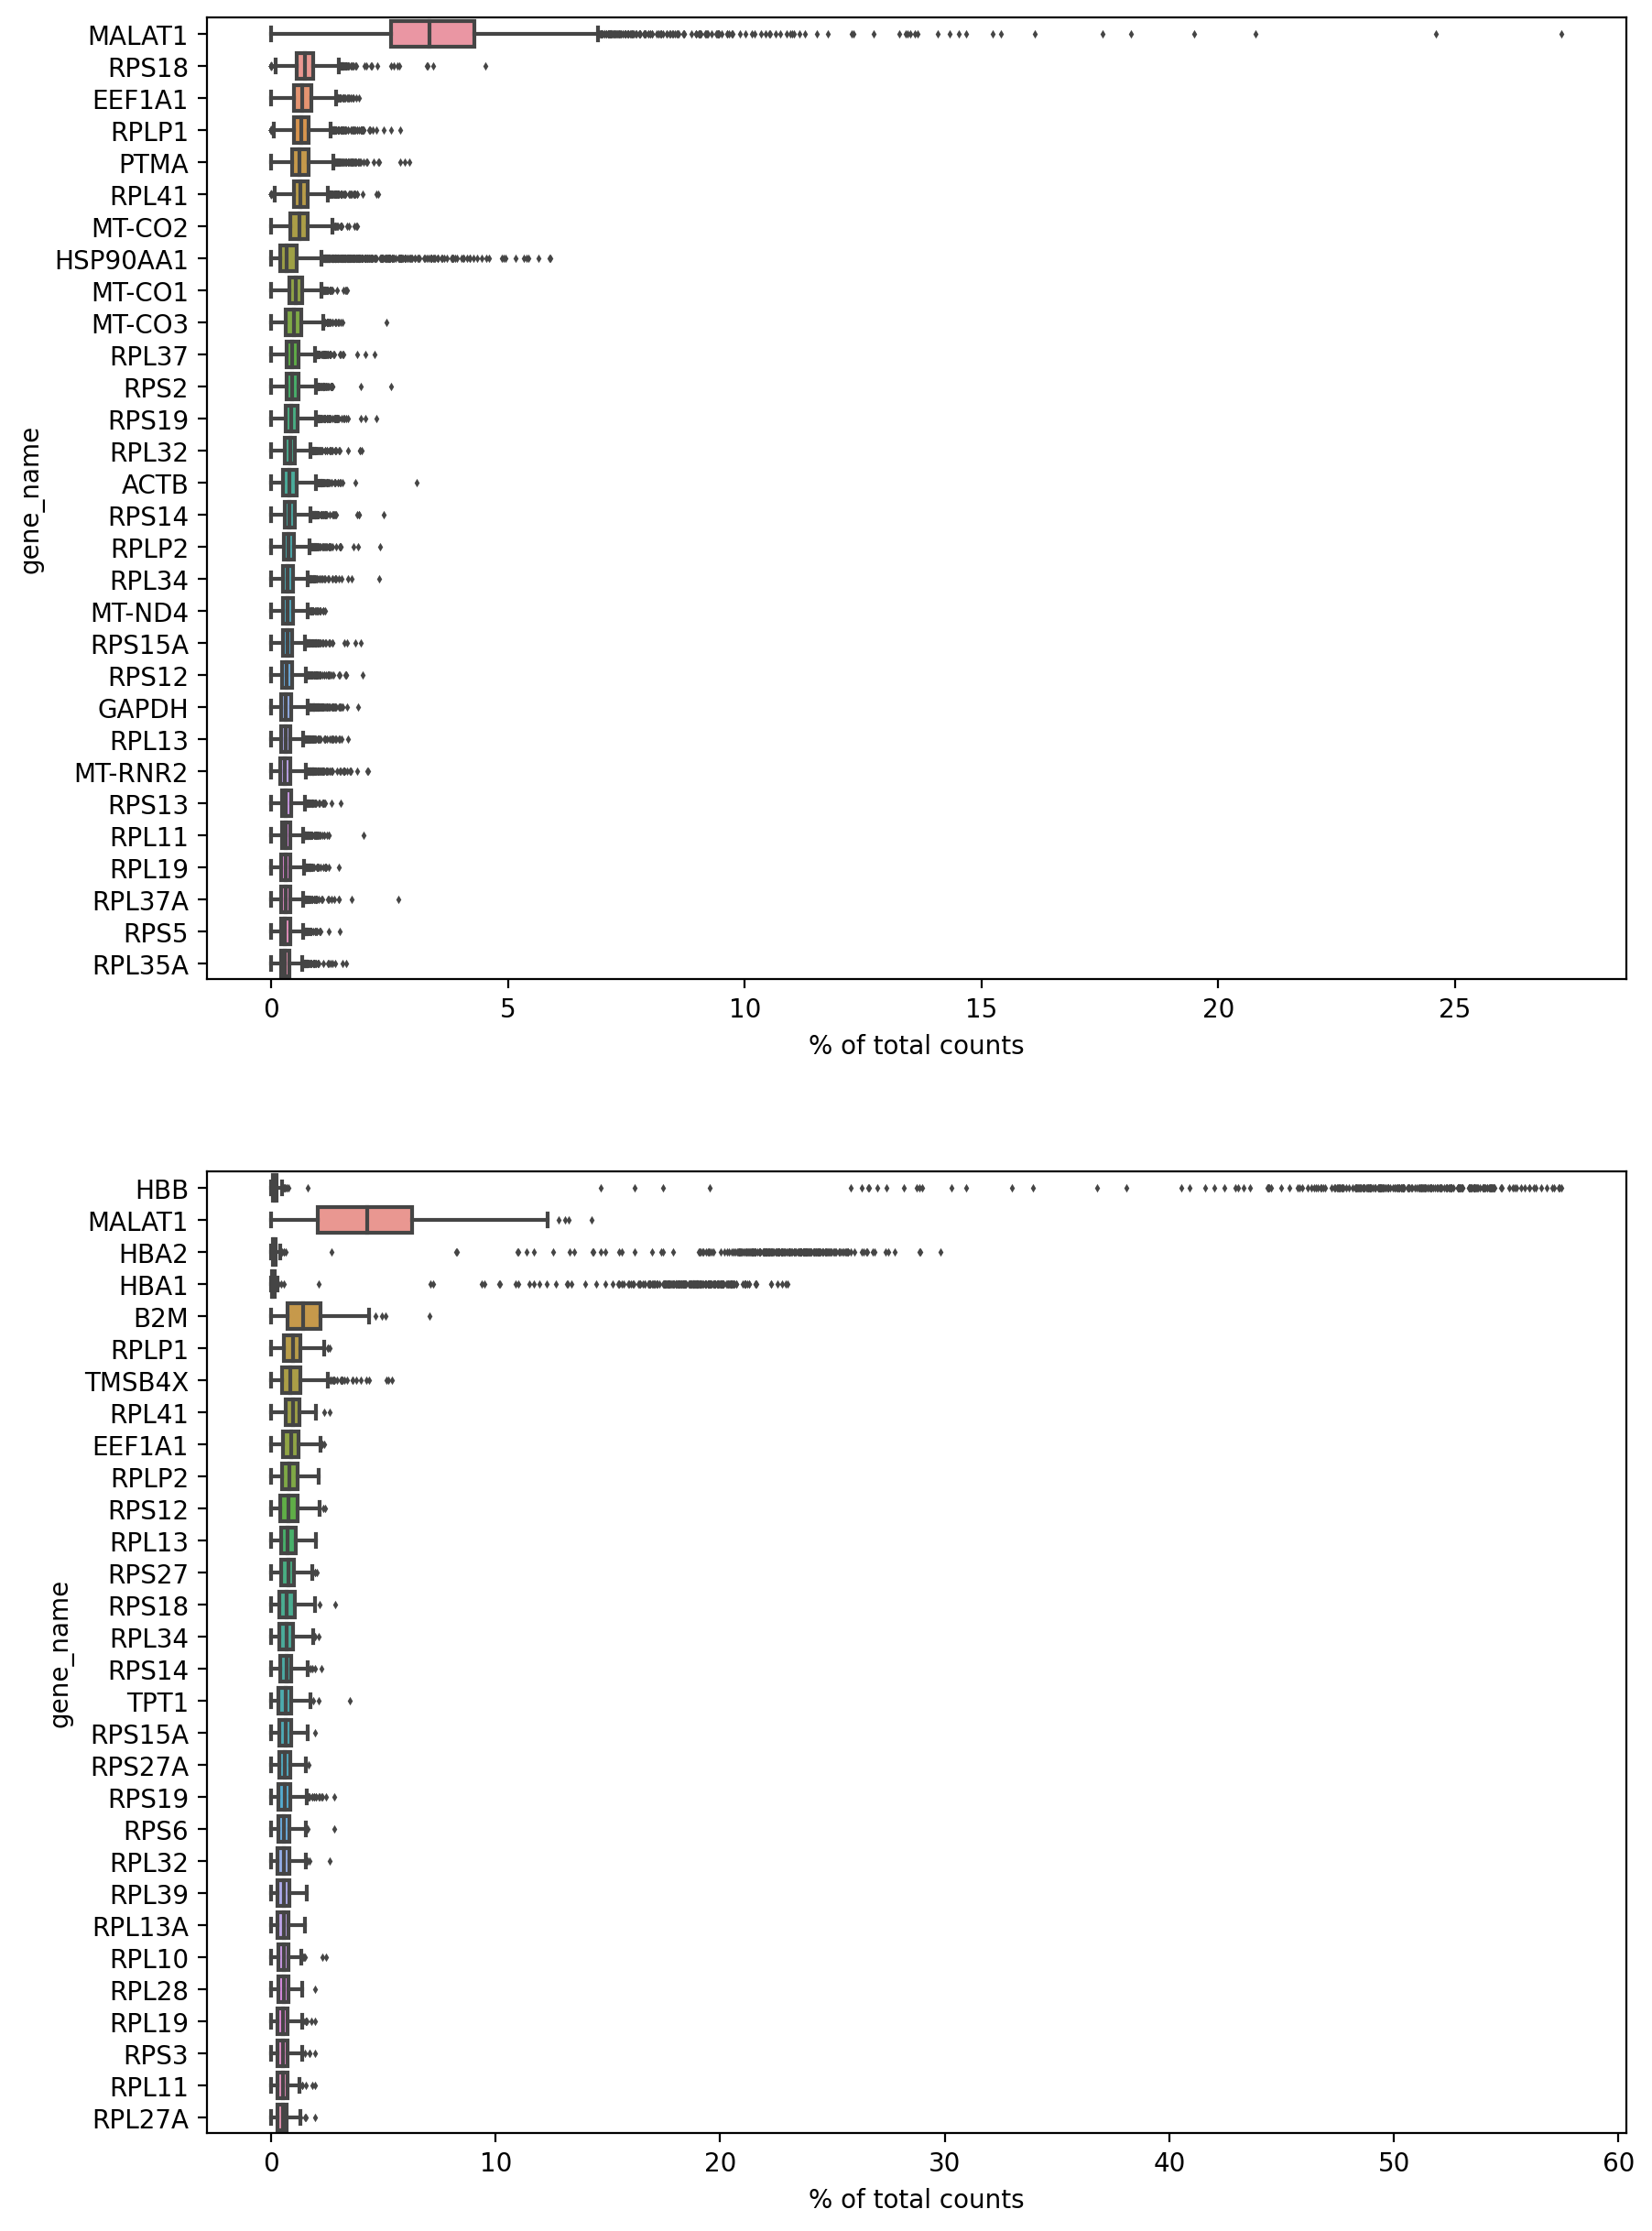

In [67]:
fig, axe = plt.subplots(2, 1, figsize=(10, 15))
for ax, adata, sp in zip(axe, adatas, samples):
    sc.pl.highest_expr_genes(adata, ax=ax, show=False)
    ax.set_title(sp)

## Visualizing count dist

In [68]:
adatas[0].obs

n_genes     n_counts
barcode                               
AAACCTGCAGTTCATG     2032  3347.000083
AAACCTGGTATTCGTG     1503  2137.000003
AAACCTGTCGAACTGT     1769  2986.999910
AAACGGGAGTGACTCT     2098  3421.999919
AAACGGGGTACTTGAC     1330  1919.999990
...                   ...          ...
TTTGGTTCAGATGGGT     2069  3450.999967
TTTGGTTGTAAGGGAA     1645  2353.999969
TTTGGTTGTTCCAACA     2069  3968.999908
TTTGTCAGTTCAACCA     1433  2064.000027
TTTGTCATCATAAAGG     1333  1708.999955

[3171 rows x 2 columns]

Text(0.5, 1.0, 'umi count')

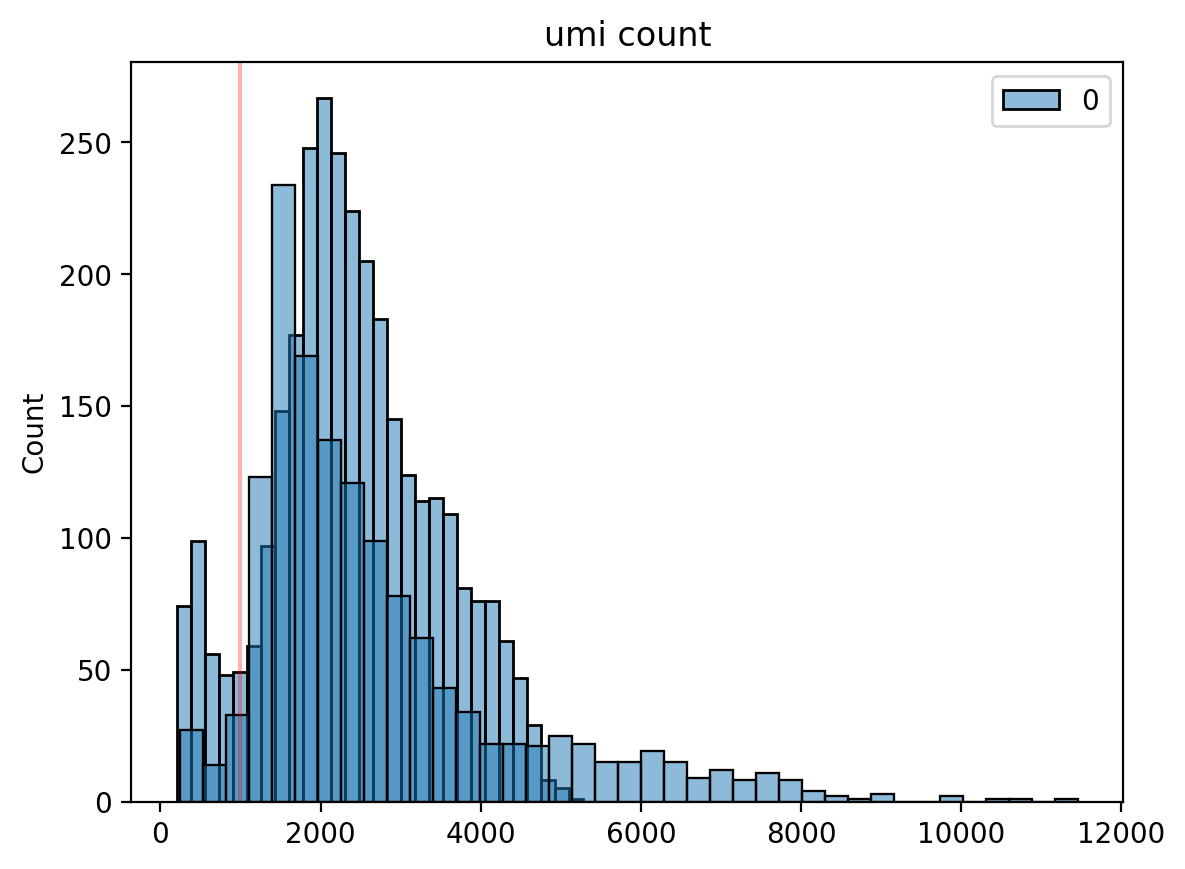

In [69]:
for adata in adatas:
    sns.histplot(adata.X.sum(axis=1))
plt.axvline(1000, color='r', alpha=.3)
plt.title('umi count')
# for adata in adatas:
#     sns.histplot(np.sum(adata.X>0, axis=1))

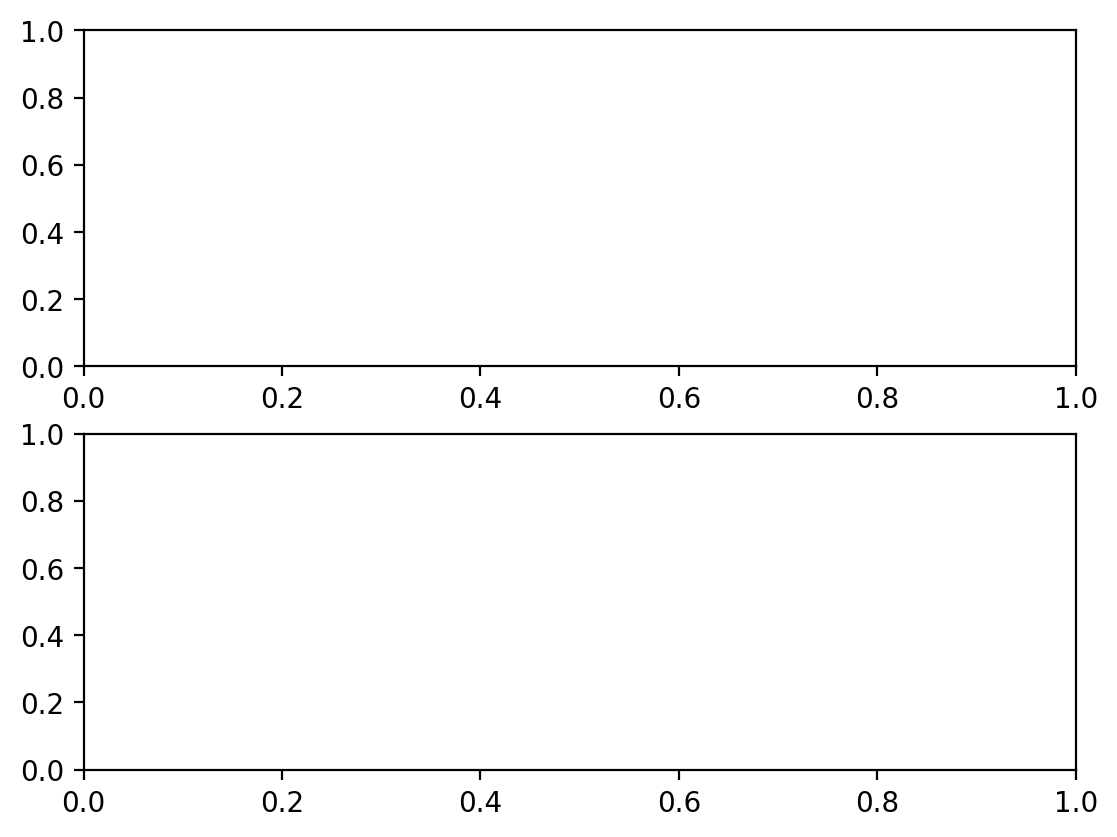

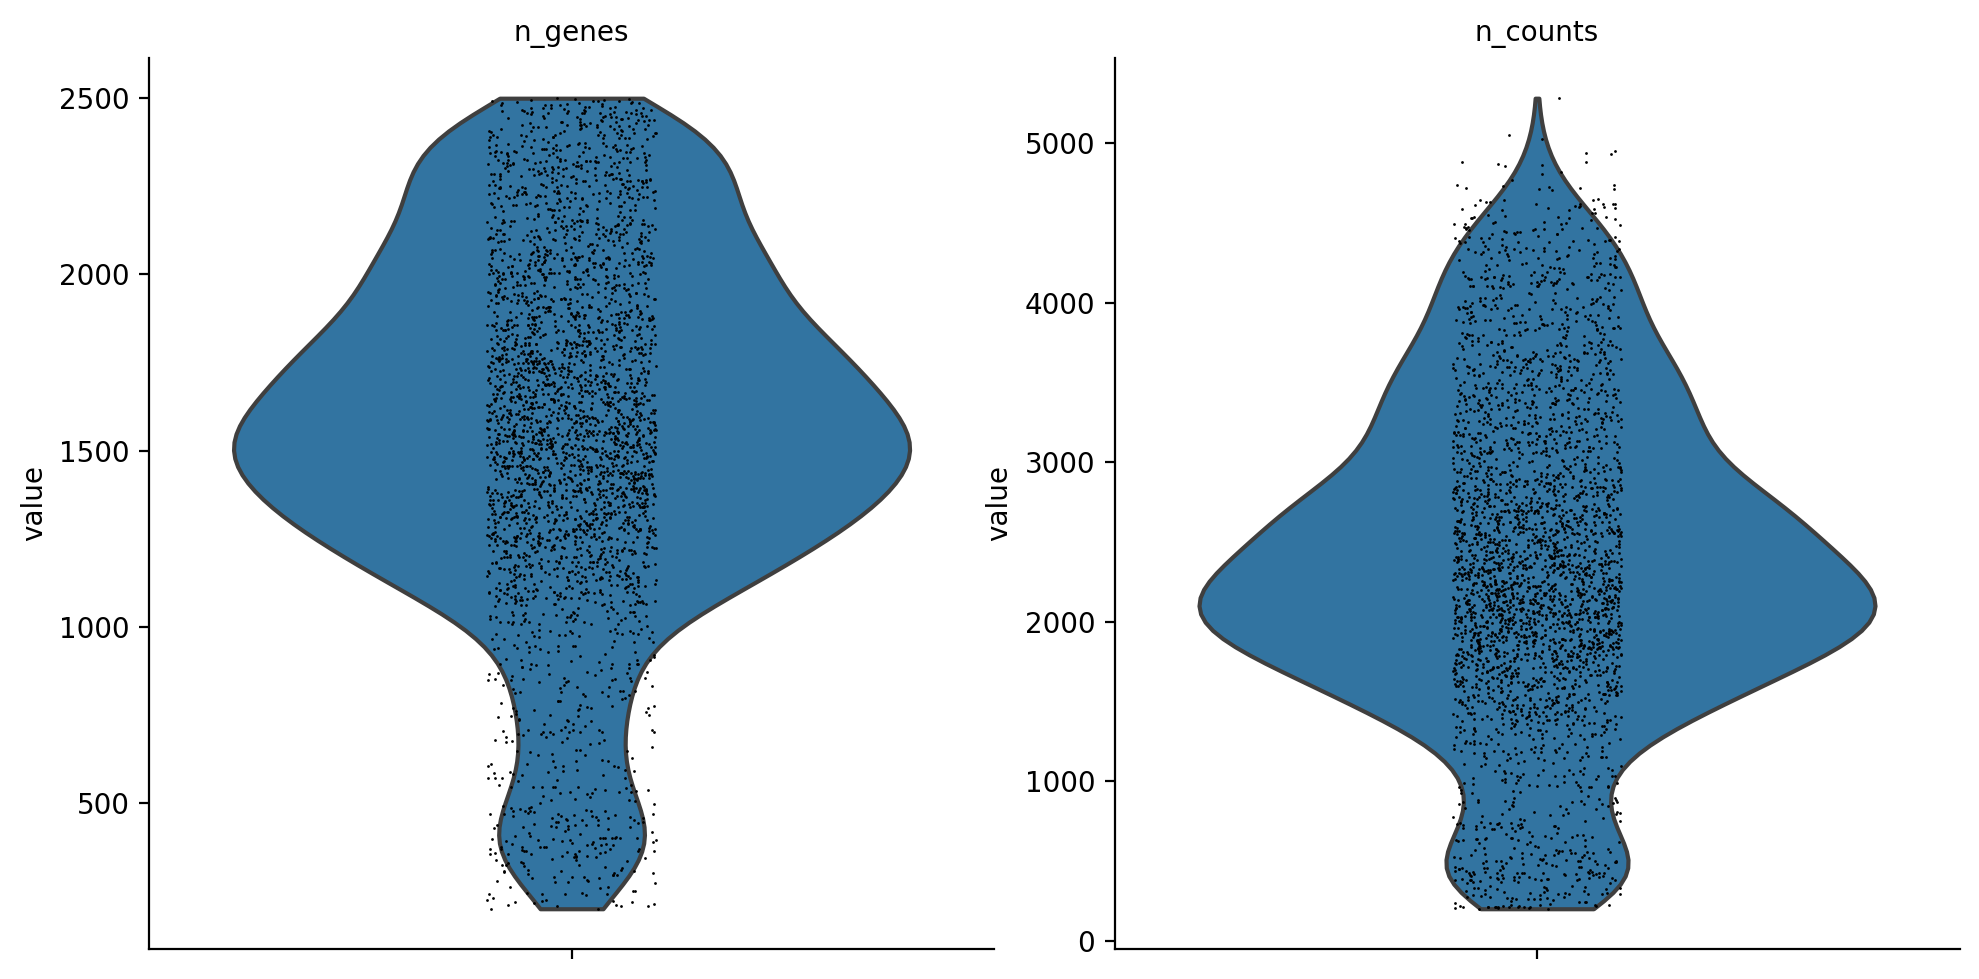

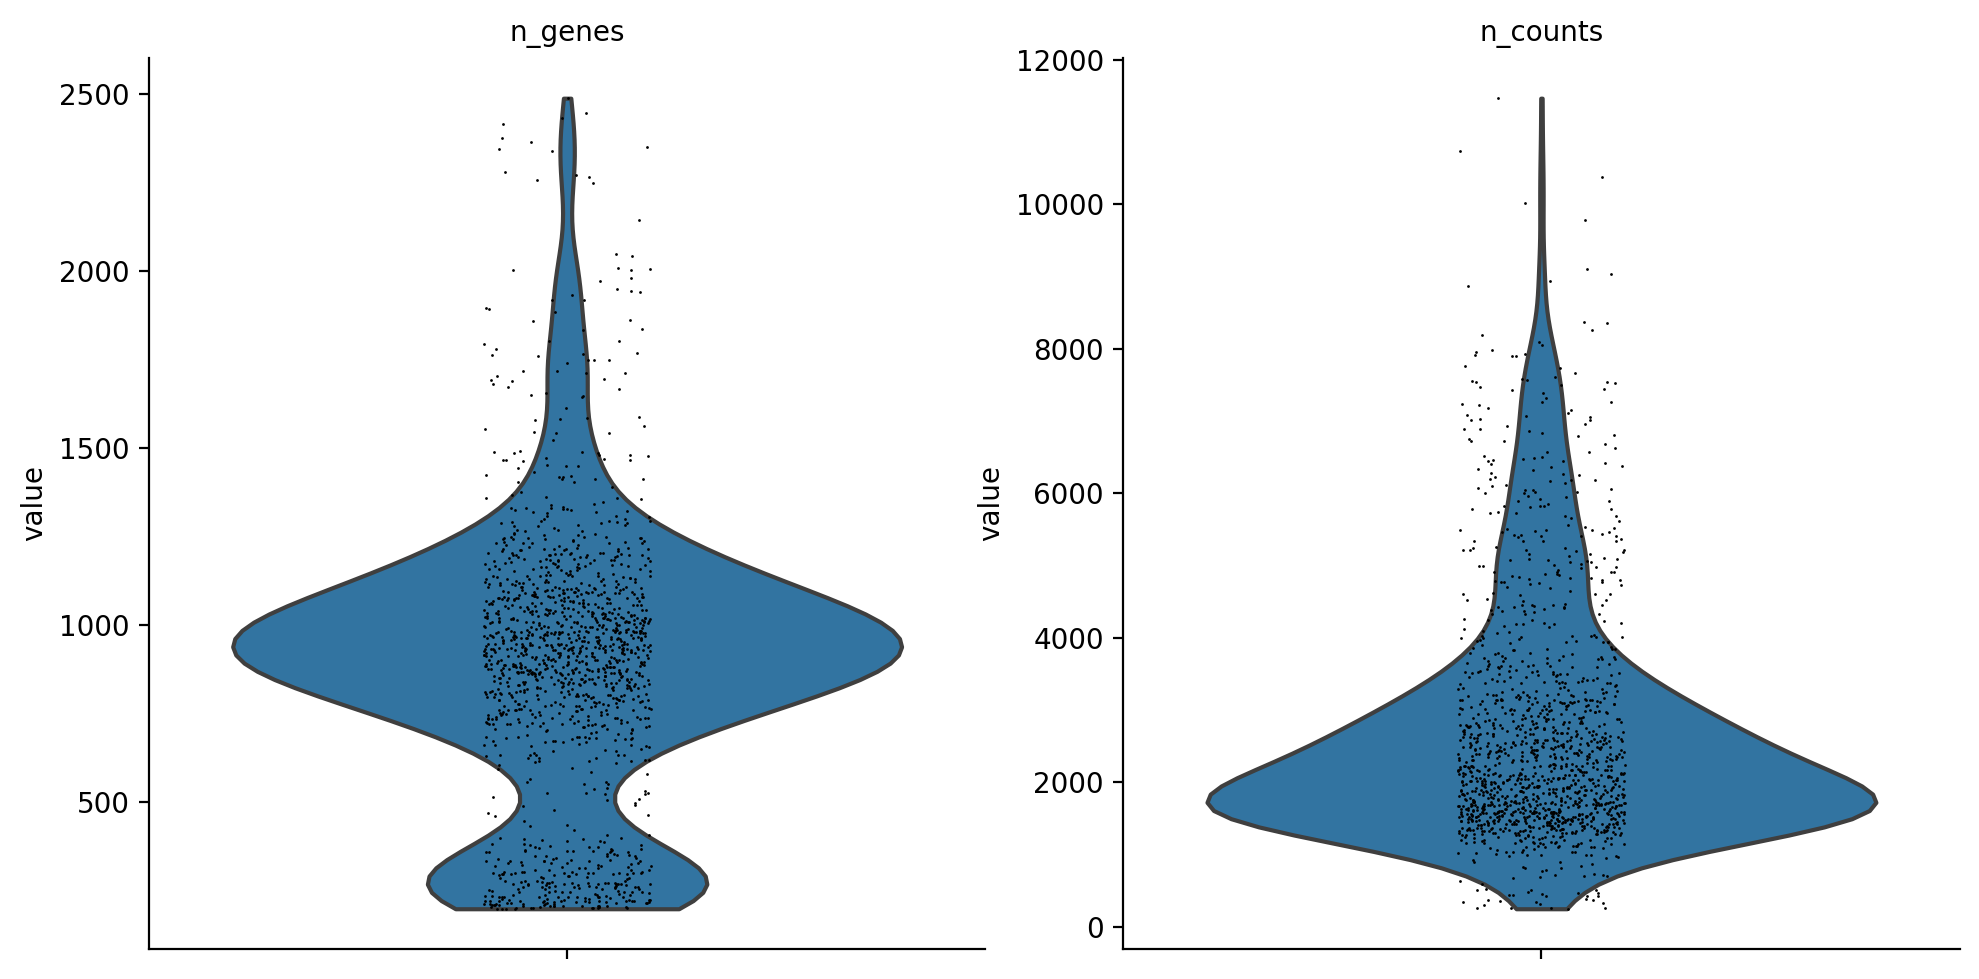

In [172]:
fig, axe = plt.subplots(2, 1)
for ax, adata in zip(axe, adatas):
    sc.pl.violin(adata, ['n_genes', 'n_counts'], jitter=True, multi_panel=True, ax=ax, show=False)
    


## Normalization

In [173]:
for adata in adatas:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

## Identify highly variable genes

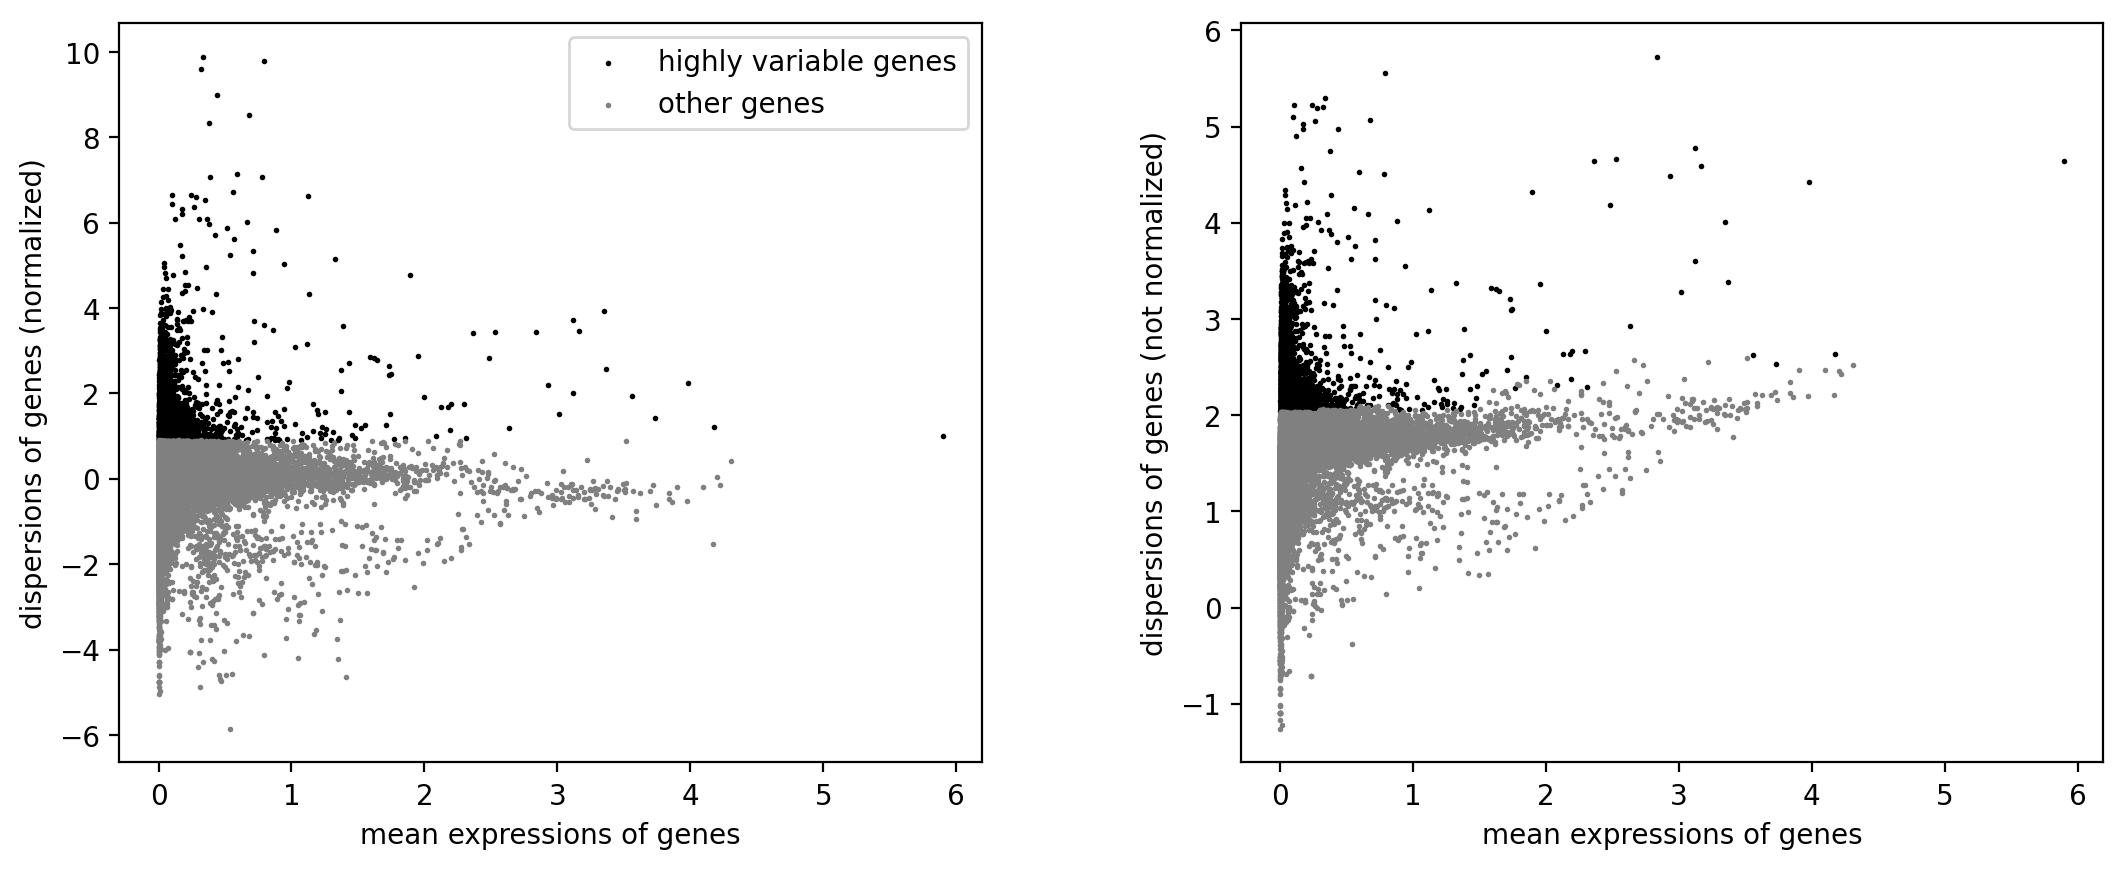

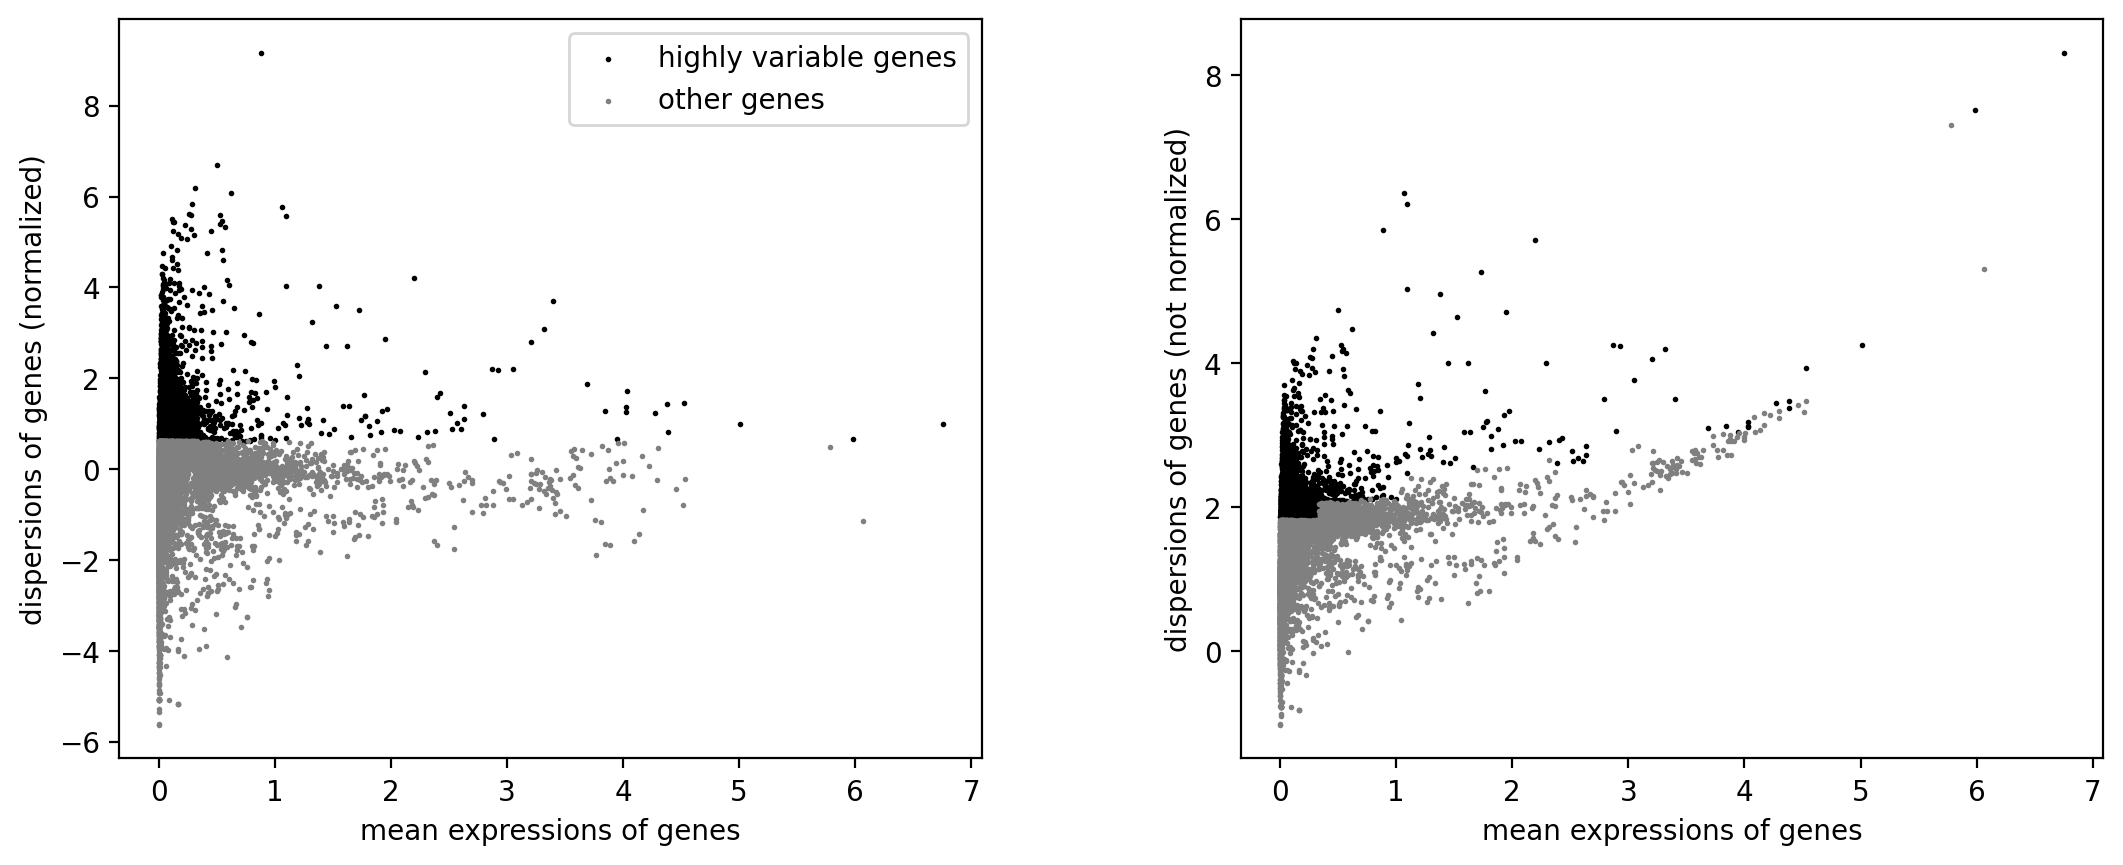

In [174]:
for adata in adatas:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=8, min_disp=0.5, n_top_genes=3000, n_bins=20, flavor="seurat")
    sc.pl.highly_variable_genes(adata)

### Freeze the data into .raw

Here, normalized data is freezed/seperated from further steps in adata.raw for later process

In [175]:
# freeze the normalized data
for adata in adatas:
    adata.raw = adata

### regress out outliers and scale the data

In [176]:
for adata in adatas:
    sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mito'])
    sc.pp.scale(adata, max_value=10)

## Clustering

number of highly variable genes

In [178]:
np.sum(adatas[0].var['highly_variable'])

3000

### PCA and choice of PCs

In [179]:
for adata in adatas:
    sc.tl.pca(adata, svd_solver='arpack', n_comps=40)

In [180]:
for adata in adatas:
    print(adata.uns['pca']['variance_ratio'][0:5].sum())

0.03648936656154206
0.05327690743746316


### PCA Overview

A general look of first 10 PCs

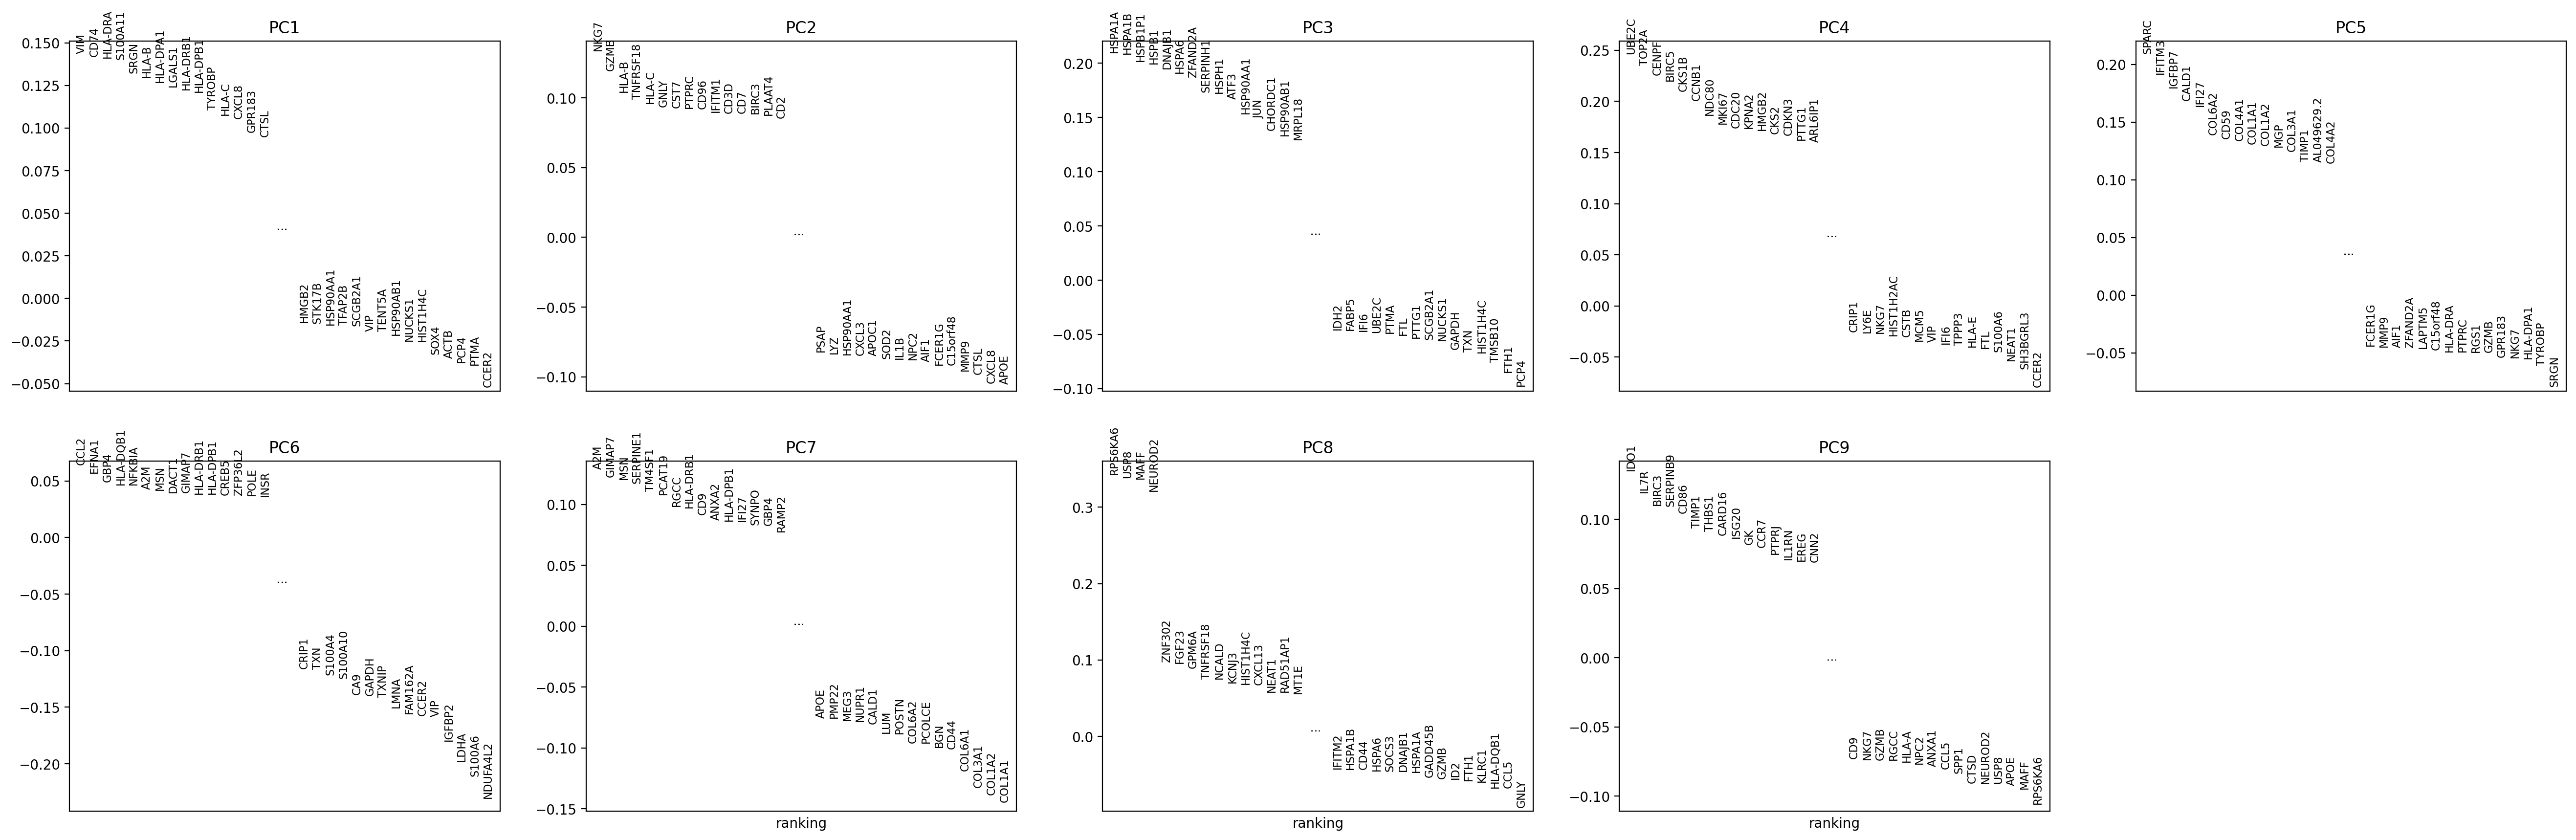

In [193]:
sc.pl.pca_loadings(adatas[0], list(range(1,10)))

The visualizatoin of variance ratio of PCs below indicates that the first 10 PCs are chosen for downstream analysis

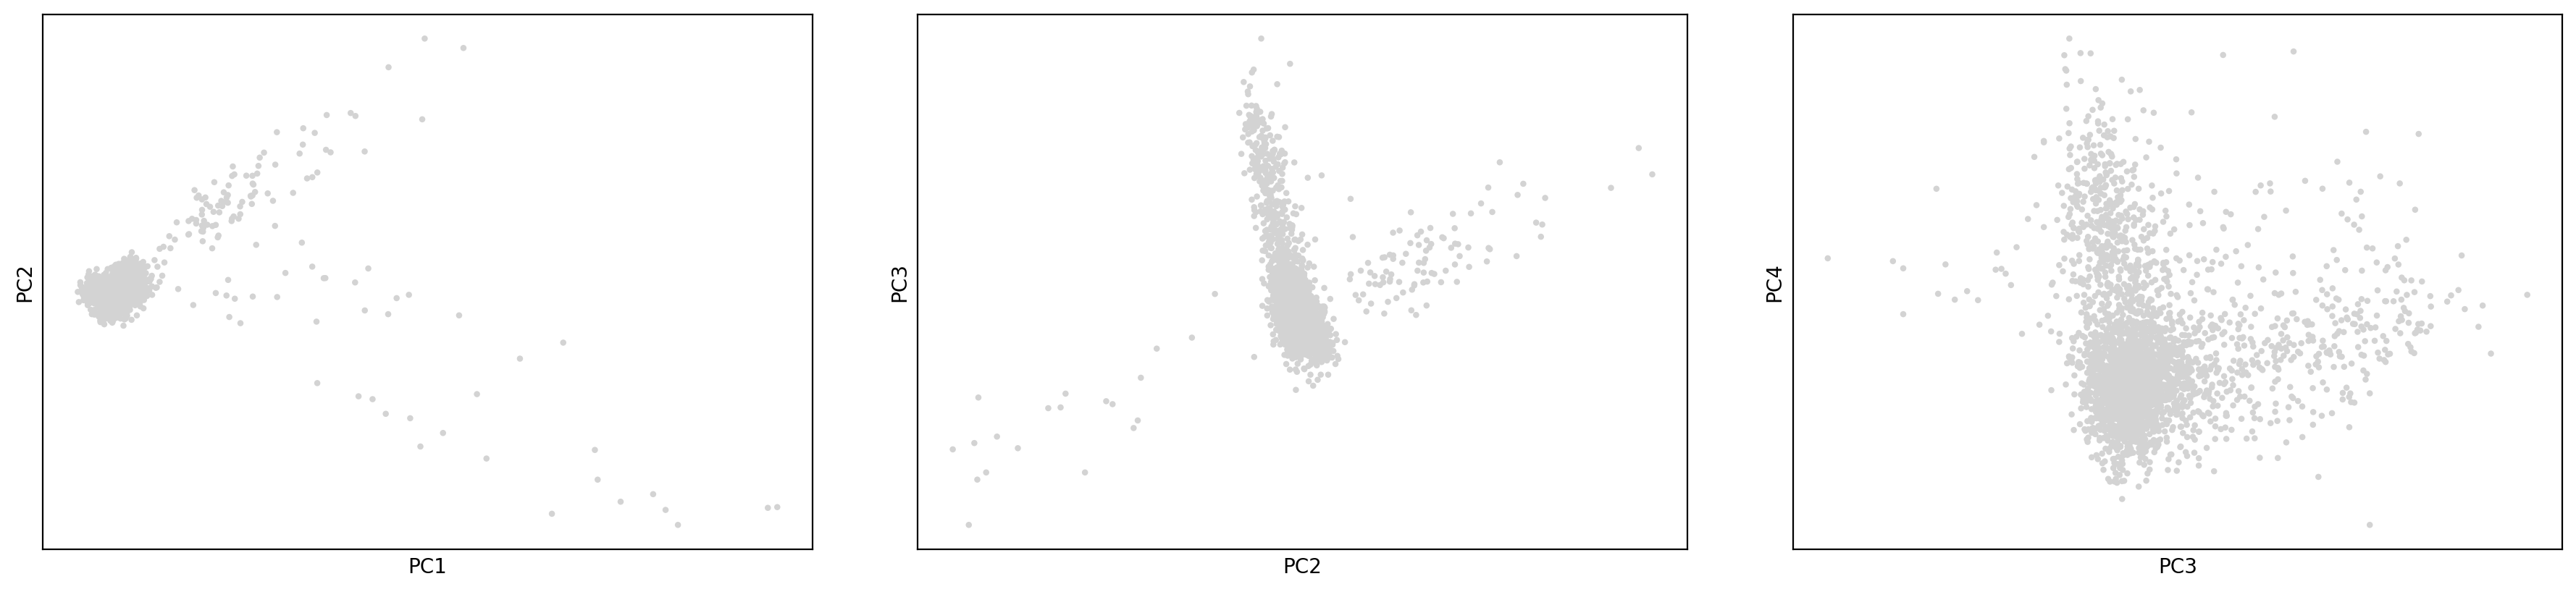

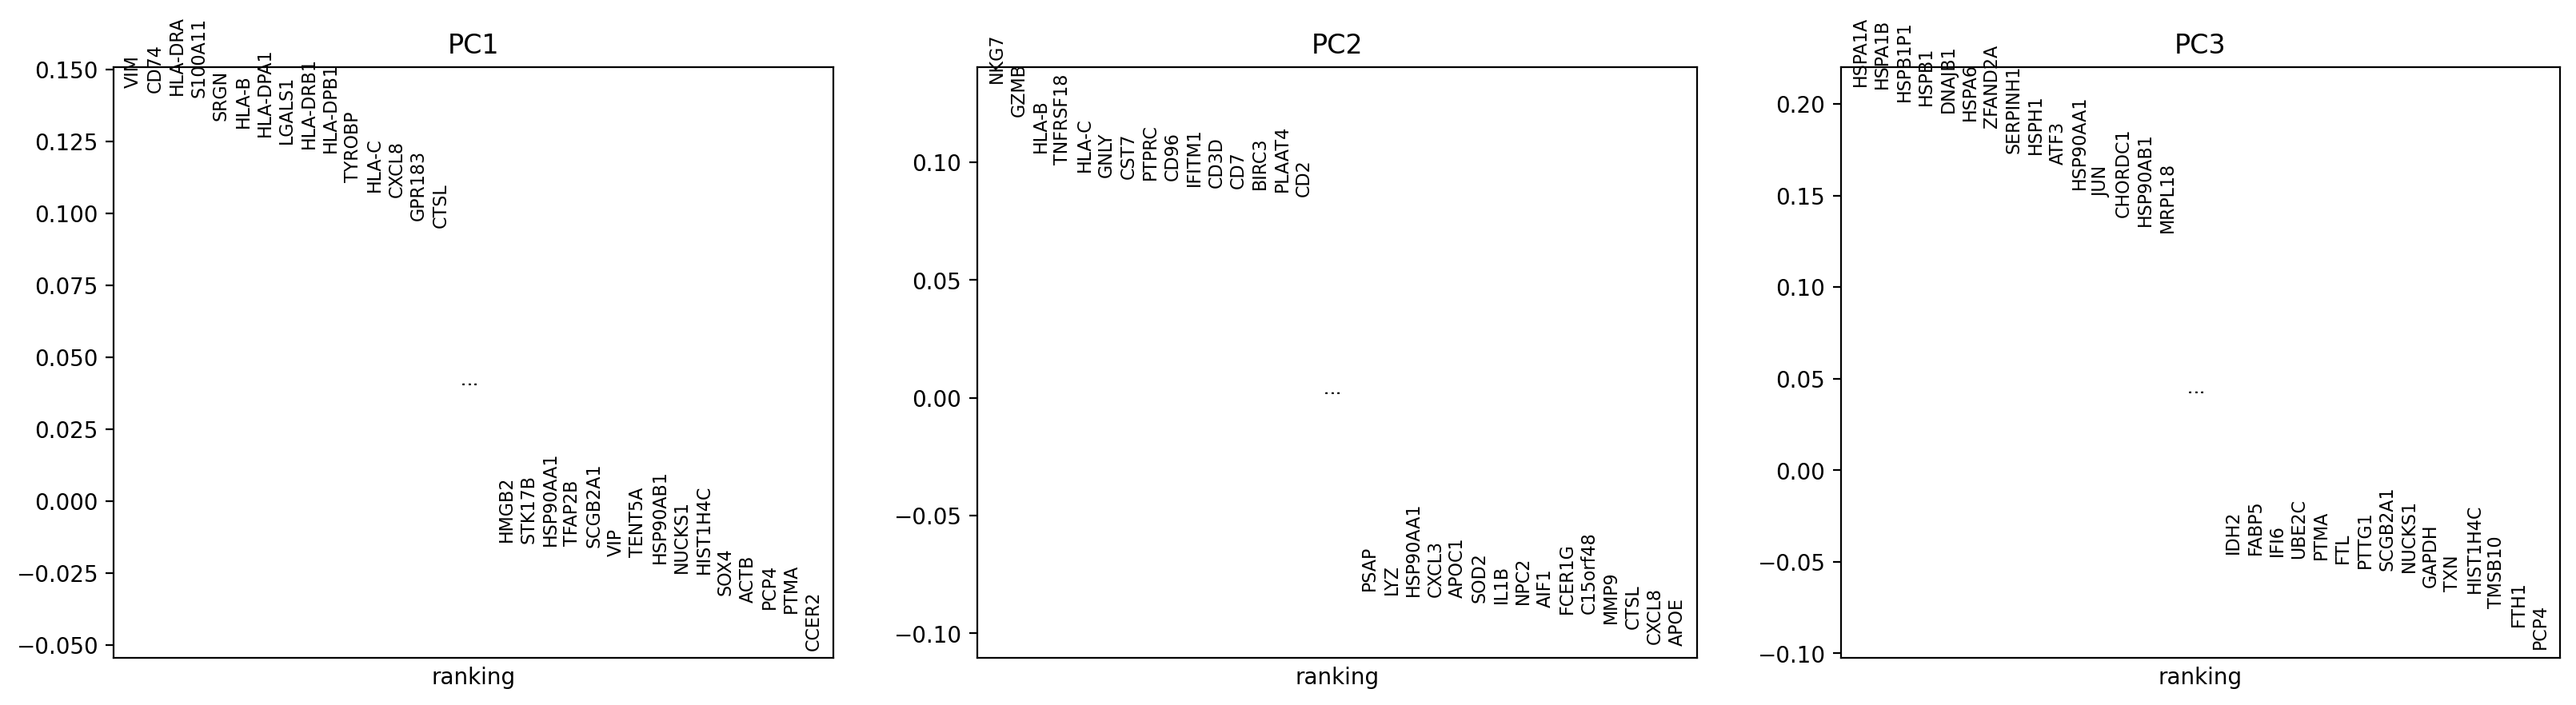

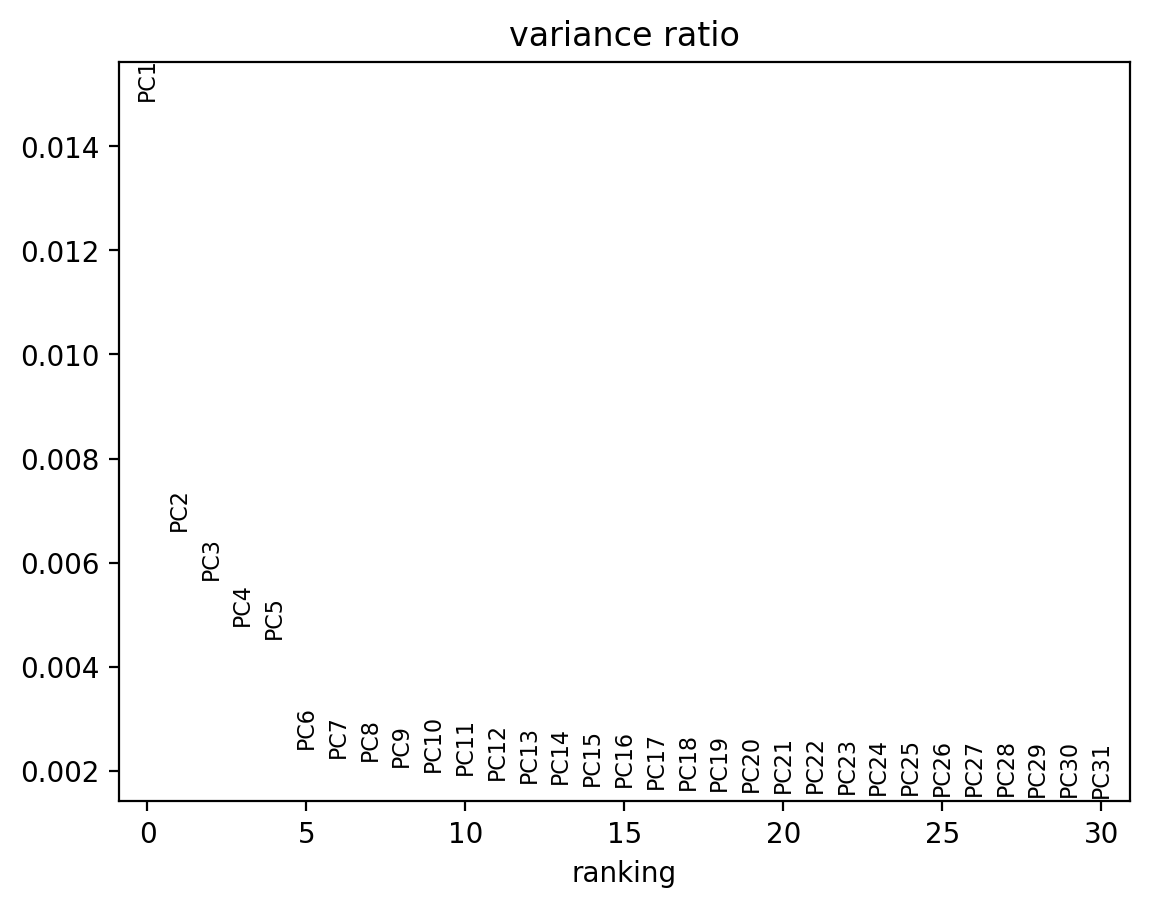

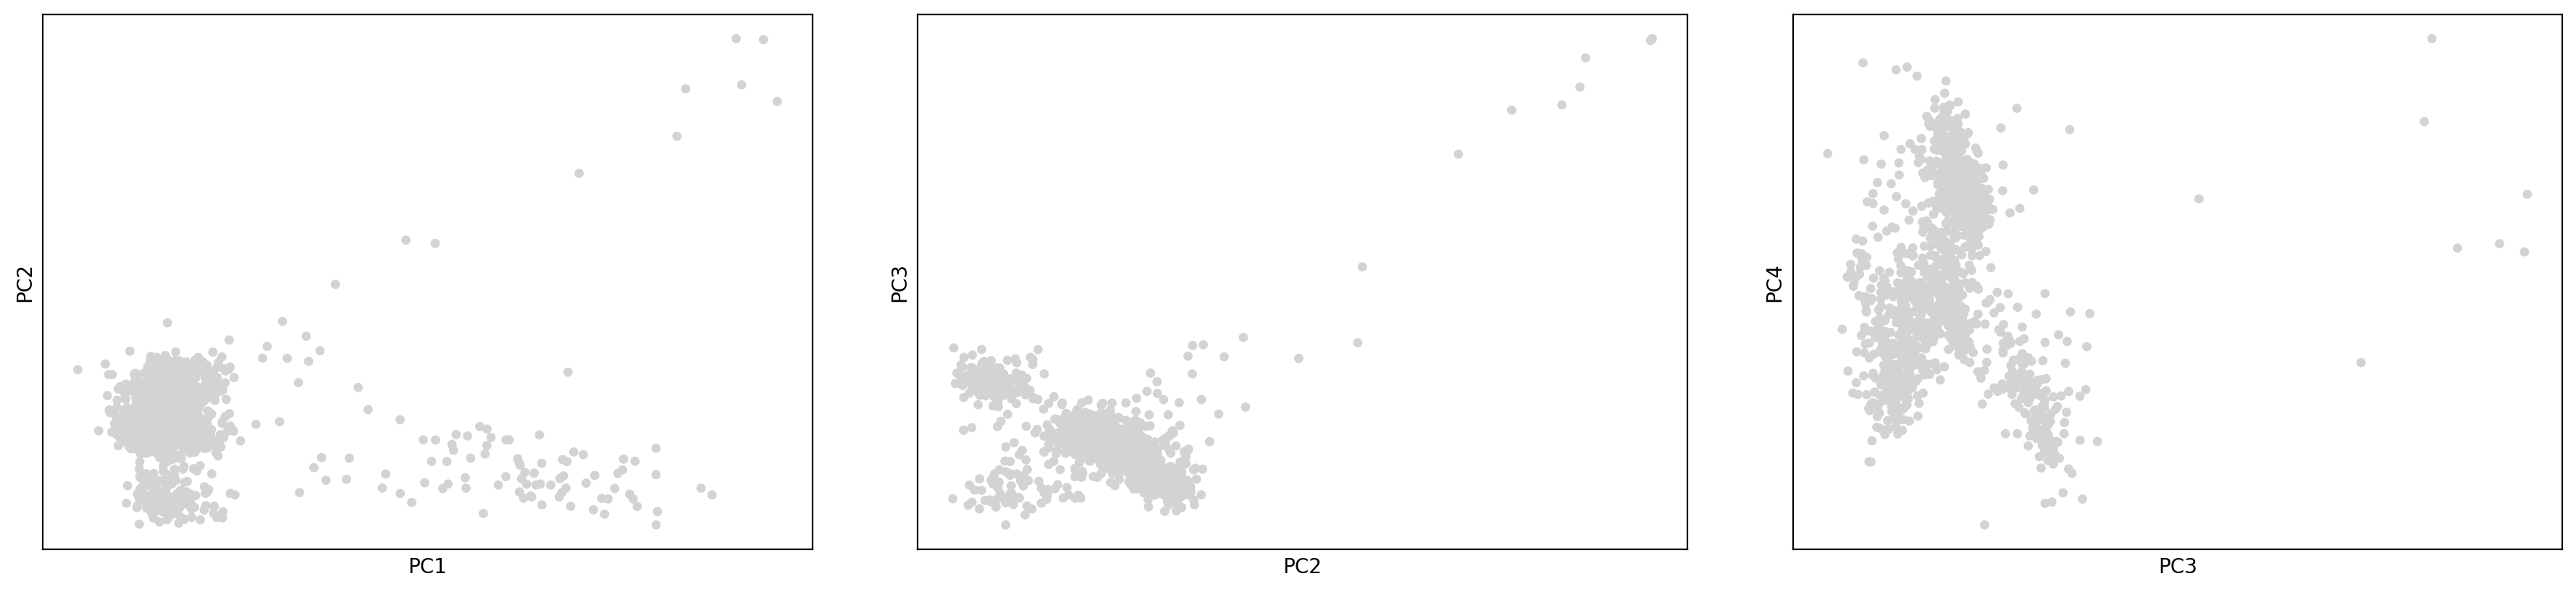

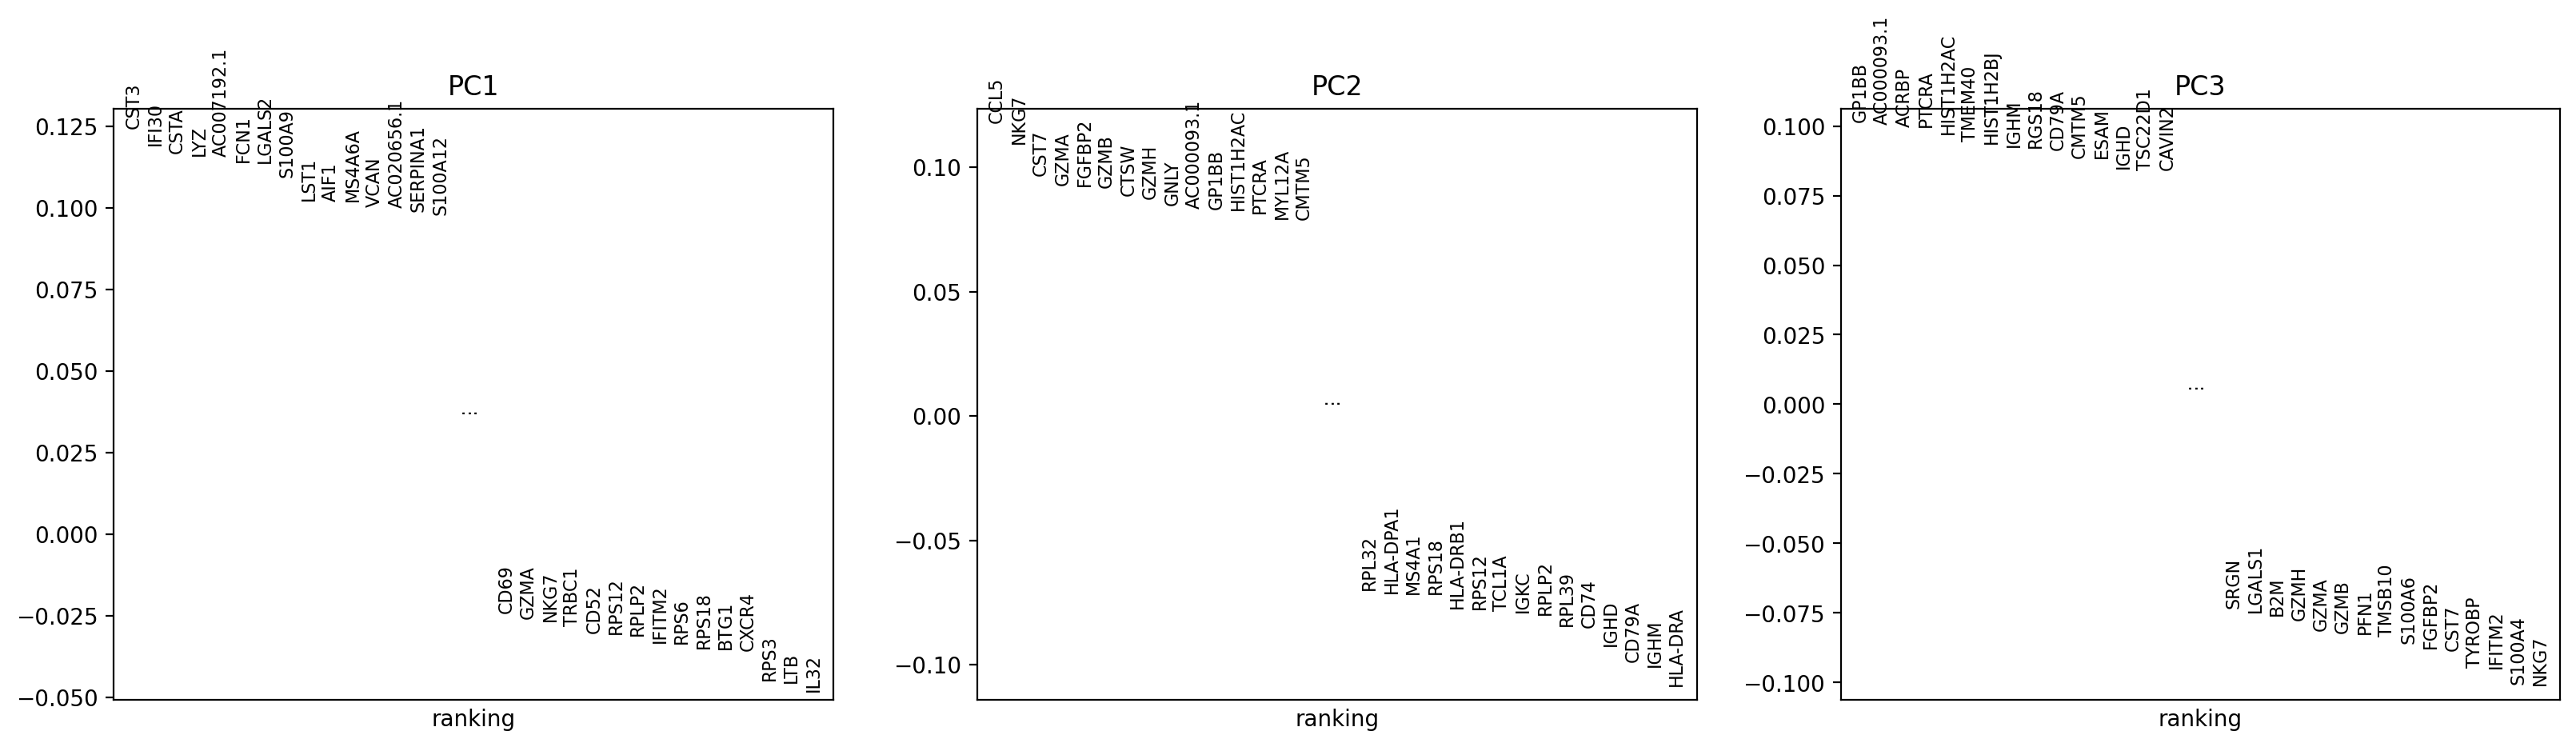

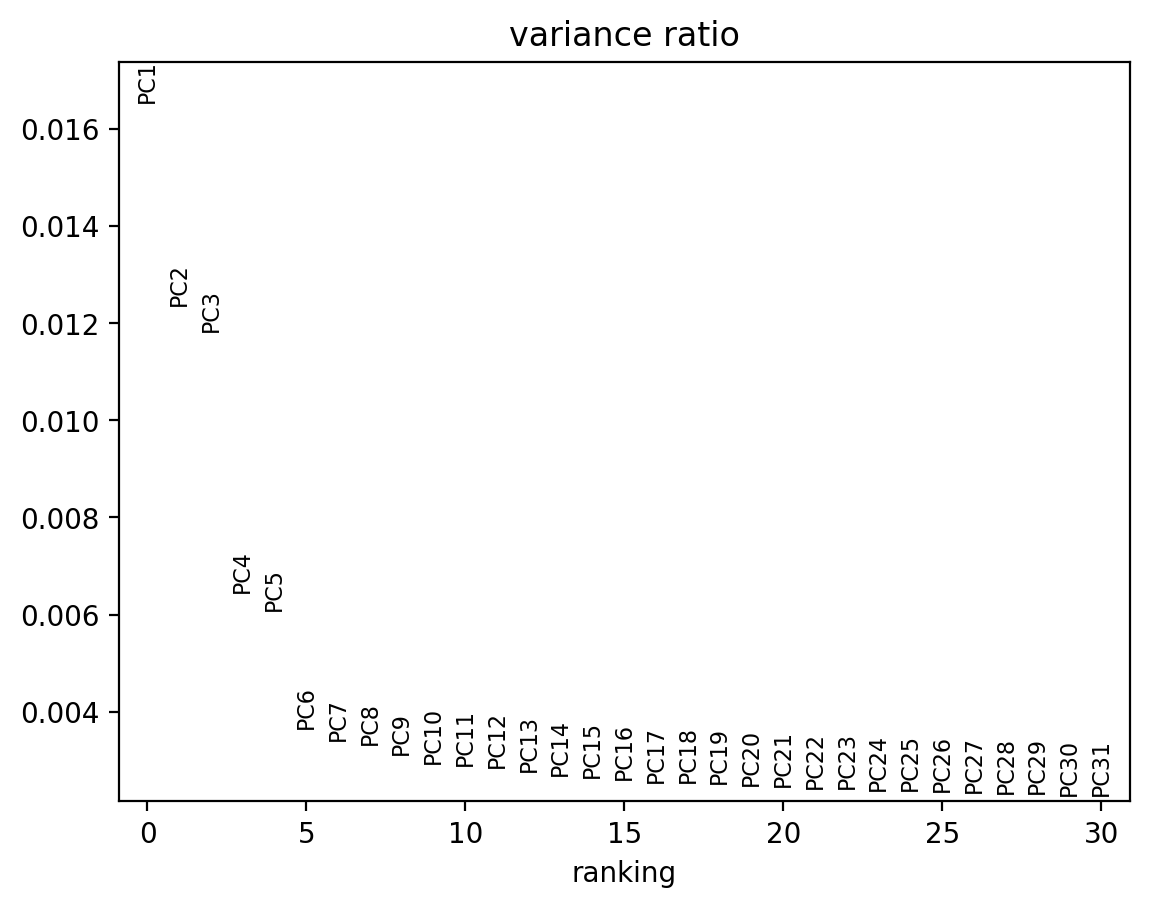

In [196]:
for adata in adatas:
    sc.pl.pca_overview(adata, components=['1,2', '2,3', '3,4'])

### Louvain clustering and t-SNE visualization

In [197]:
# Louvain clustering
# Cluster the cells using Louvain clustering
for adata in adatas:
    sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10, knn=True)
    sc.tl.louvain(adata, resolution=0.6)

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


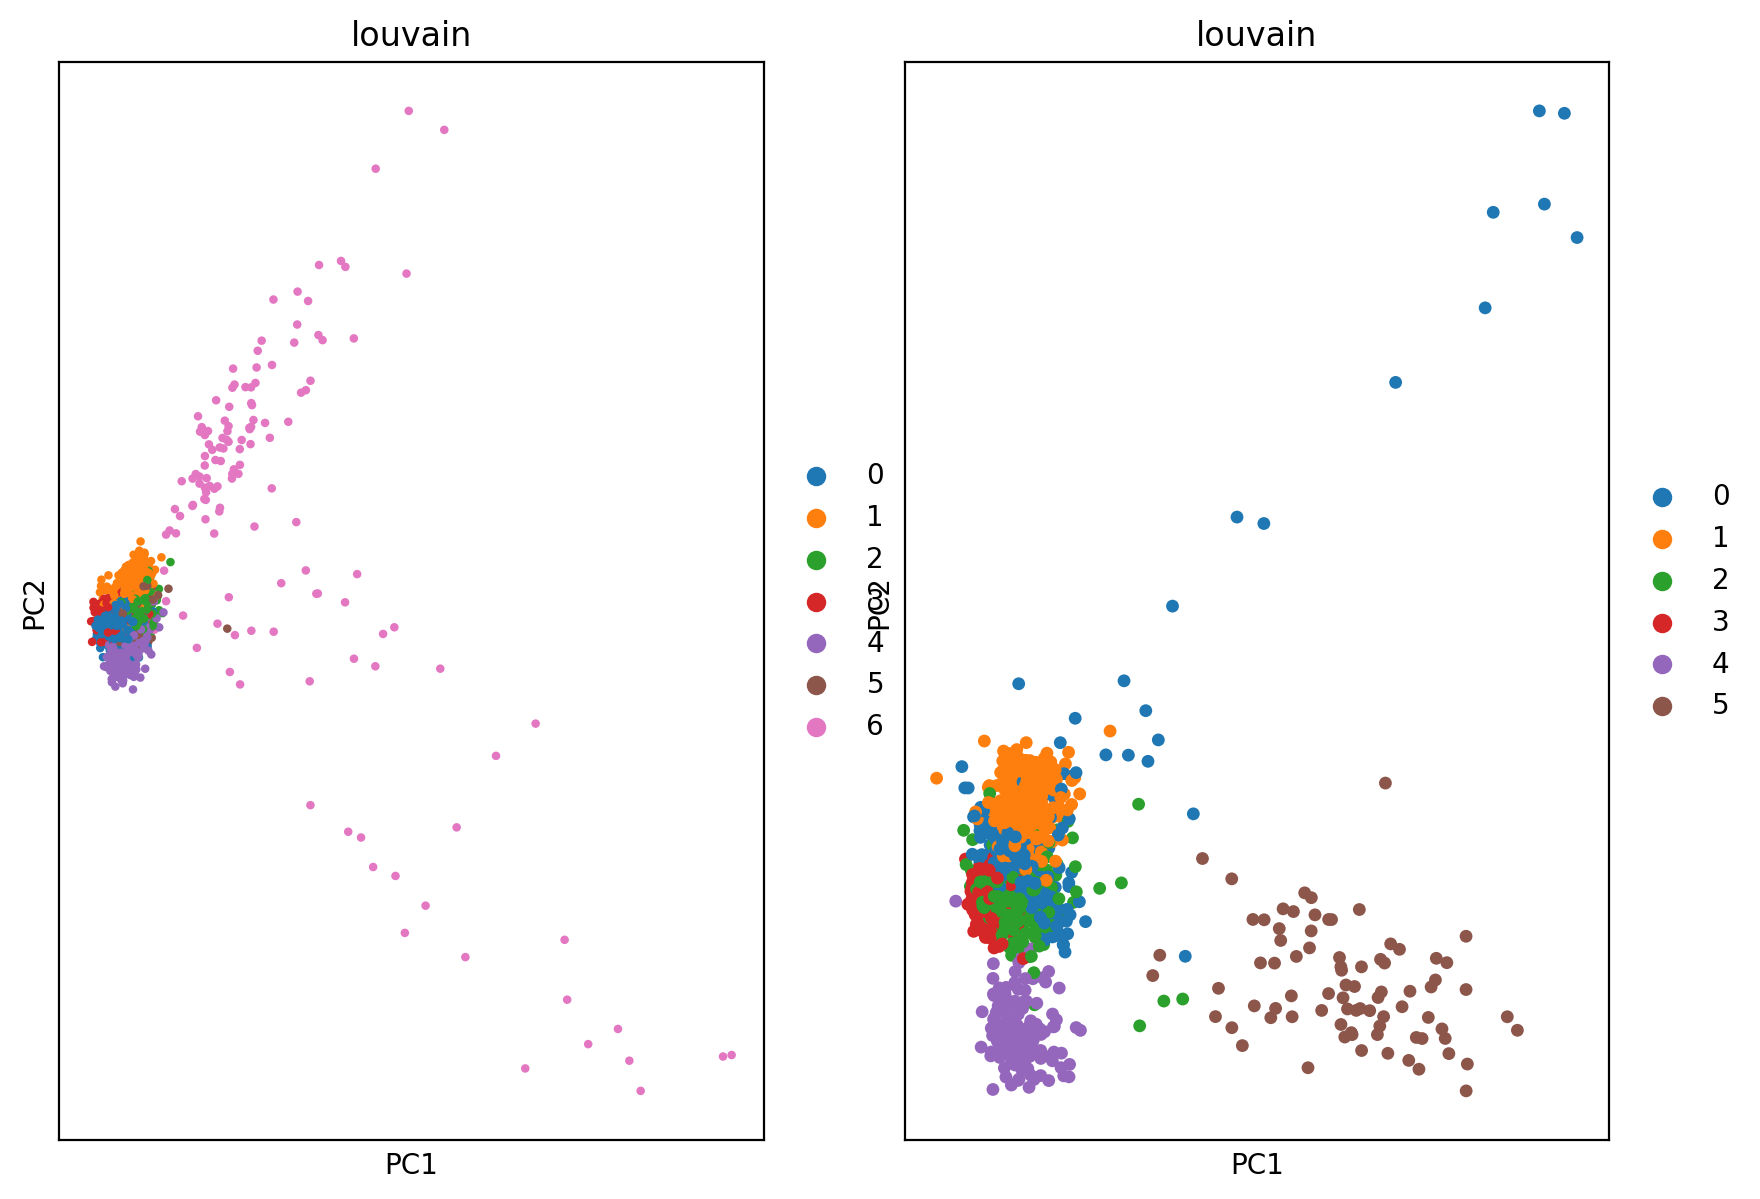

In [203]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, axe = plt.subplots(1, 2, figsize=(10, 7))
for adata, ax in zip(adatas, axe):
    sc.pl.pca(adata, color='louvain', show=False, ax=ax)

In [204]:
# perform t-sne on top 10 pcs
for adata, ax in zip(adatas, axe):
    sc.tl.tsne(adata, n_pcs=10)

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


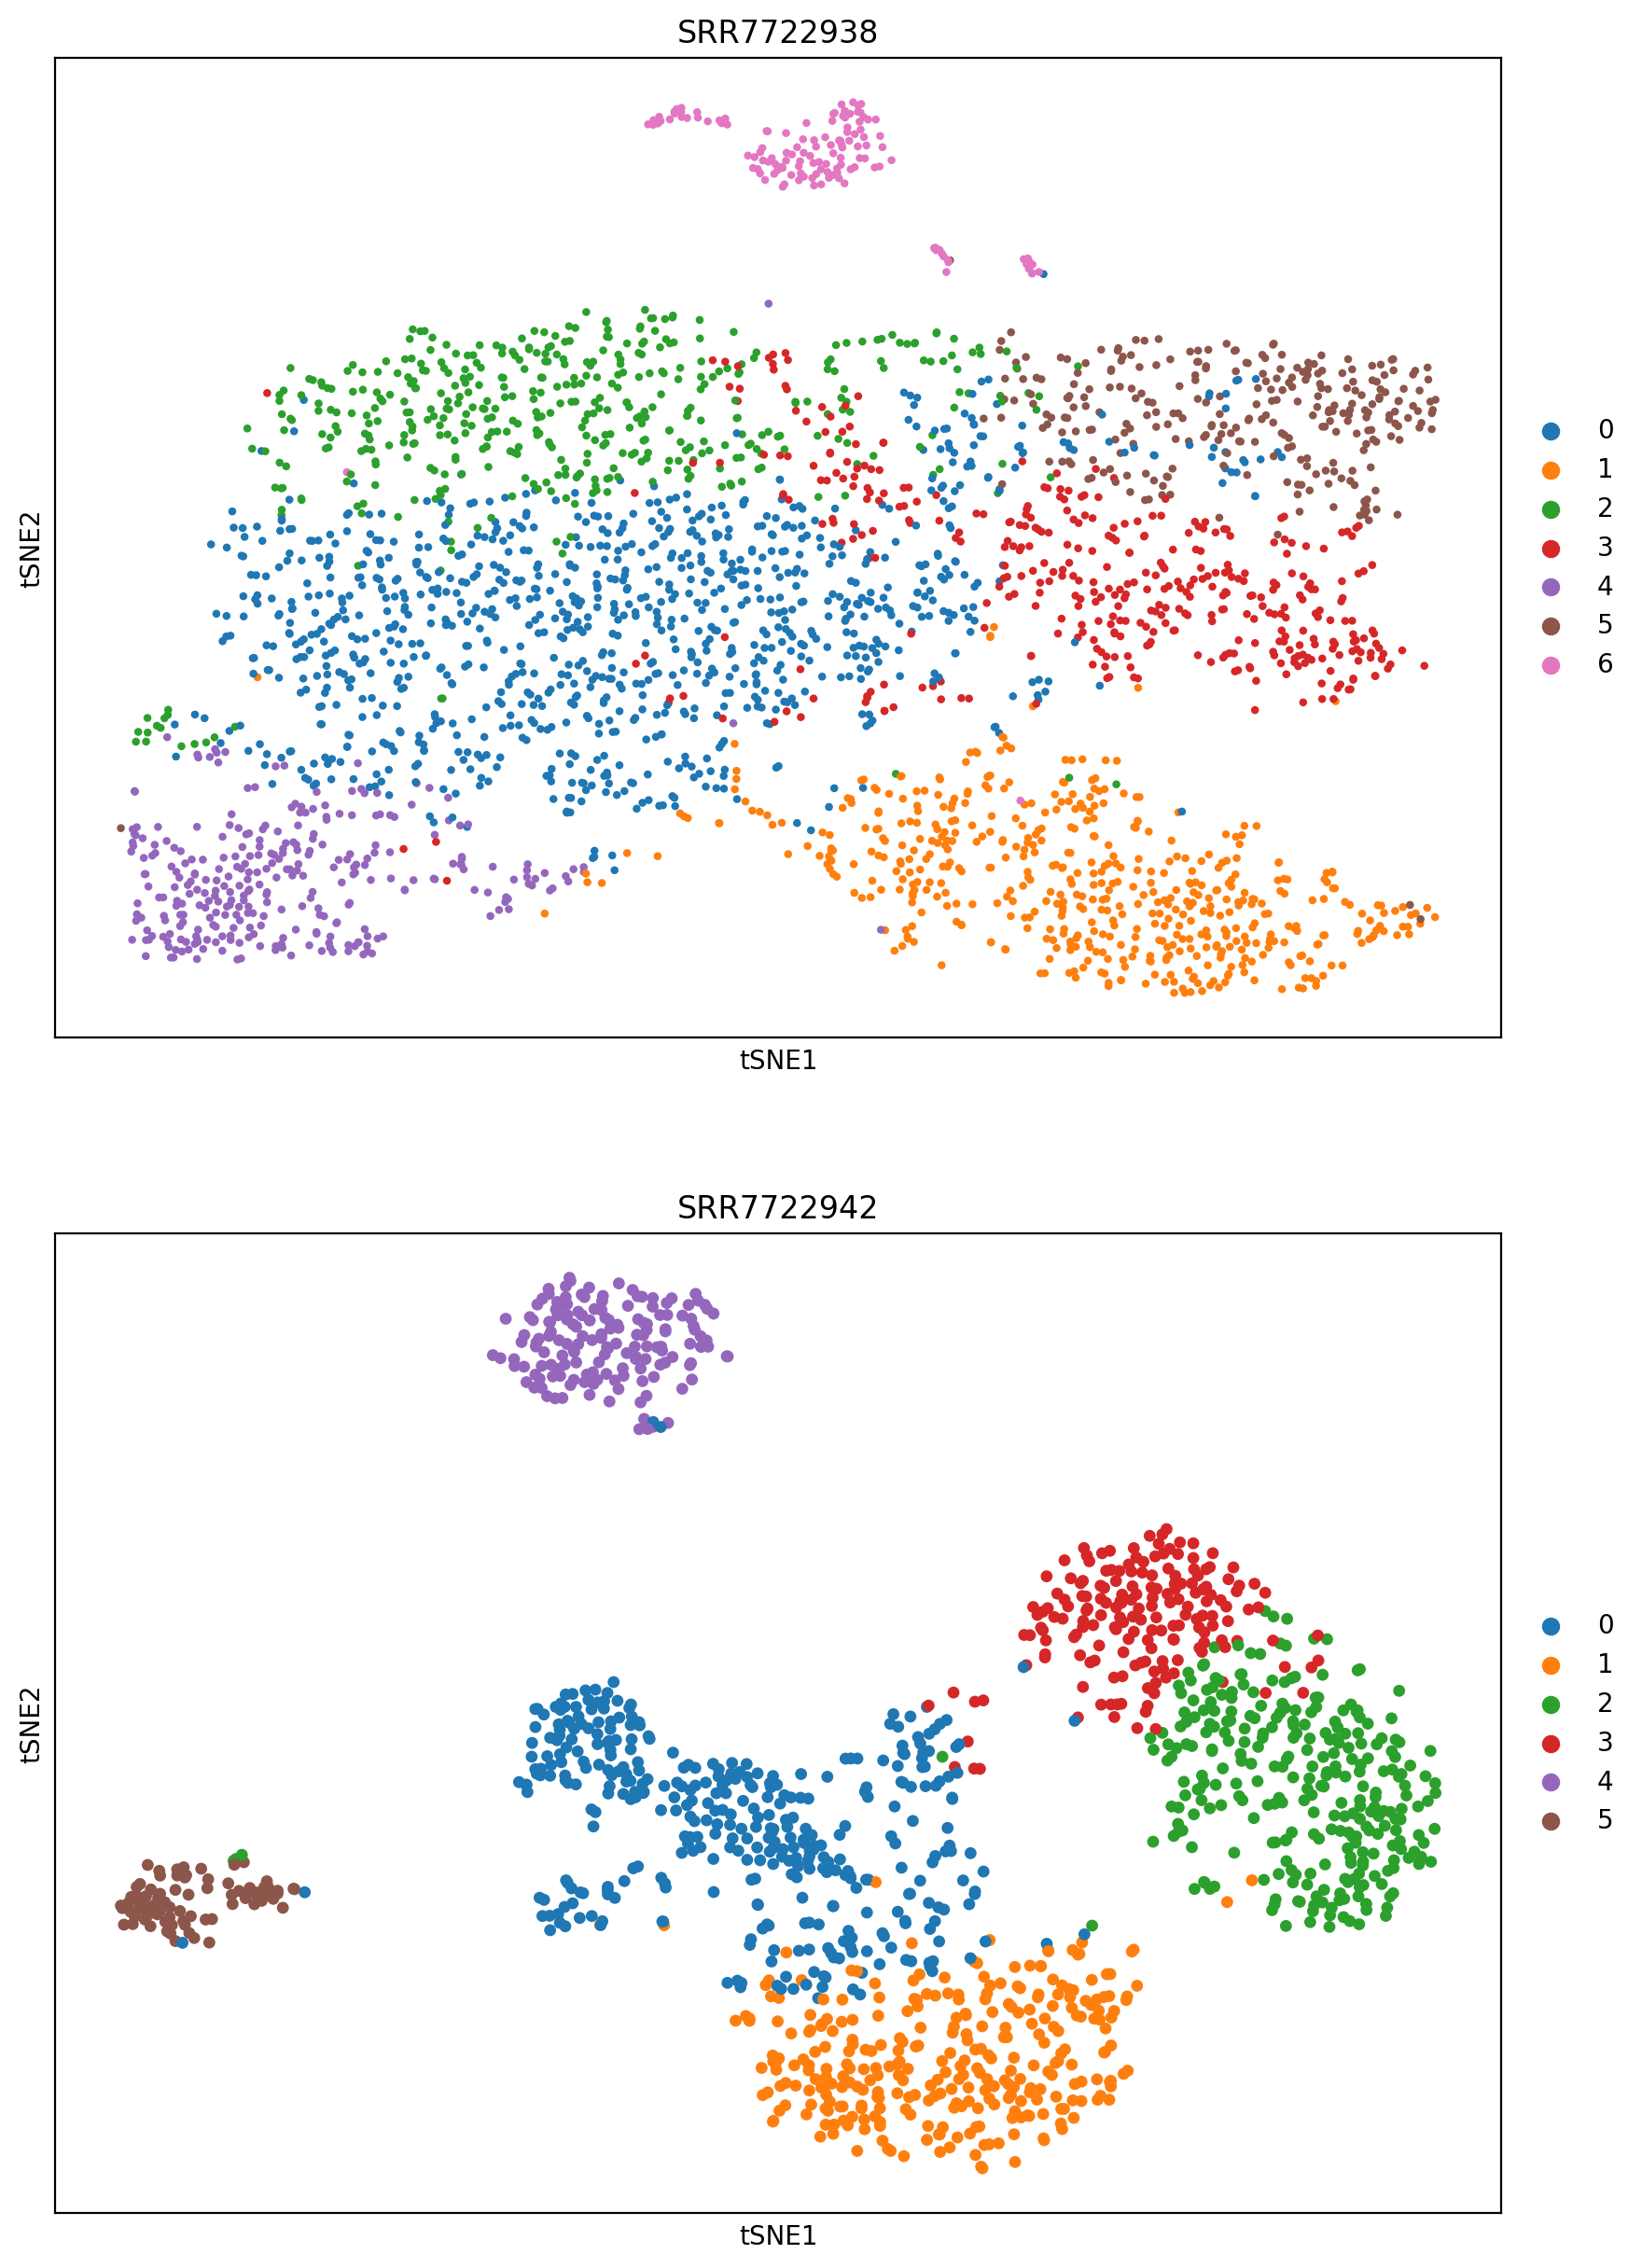

In [206]:
# t-sne visualization
fig, axe = plt.subplots(2, 1, figsize=(10, 15))
for adata, ax, sp in zip(adatas, axe, samples):
    sc.pl.tsne(adata, color='louvain', show=False, ax=ax)
    ax.set_title(sp)

## Find Marker genes

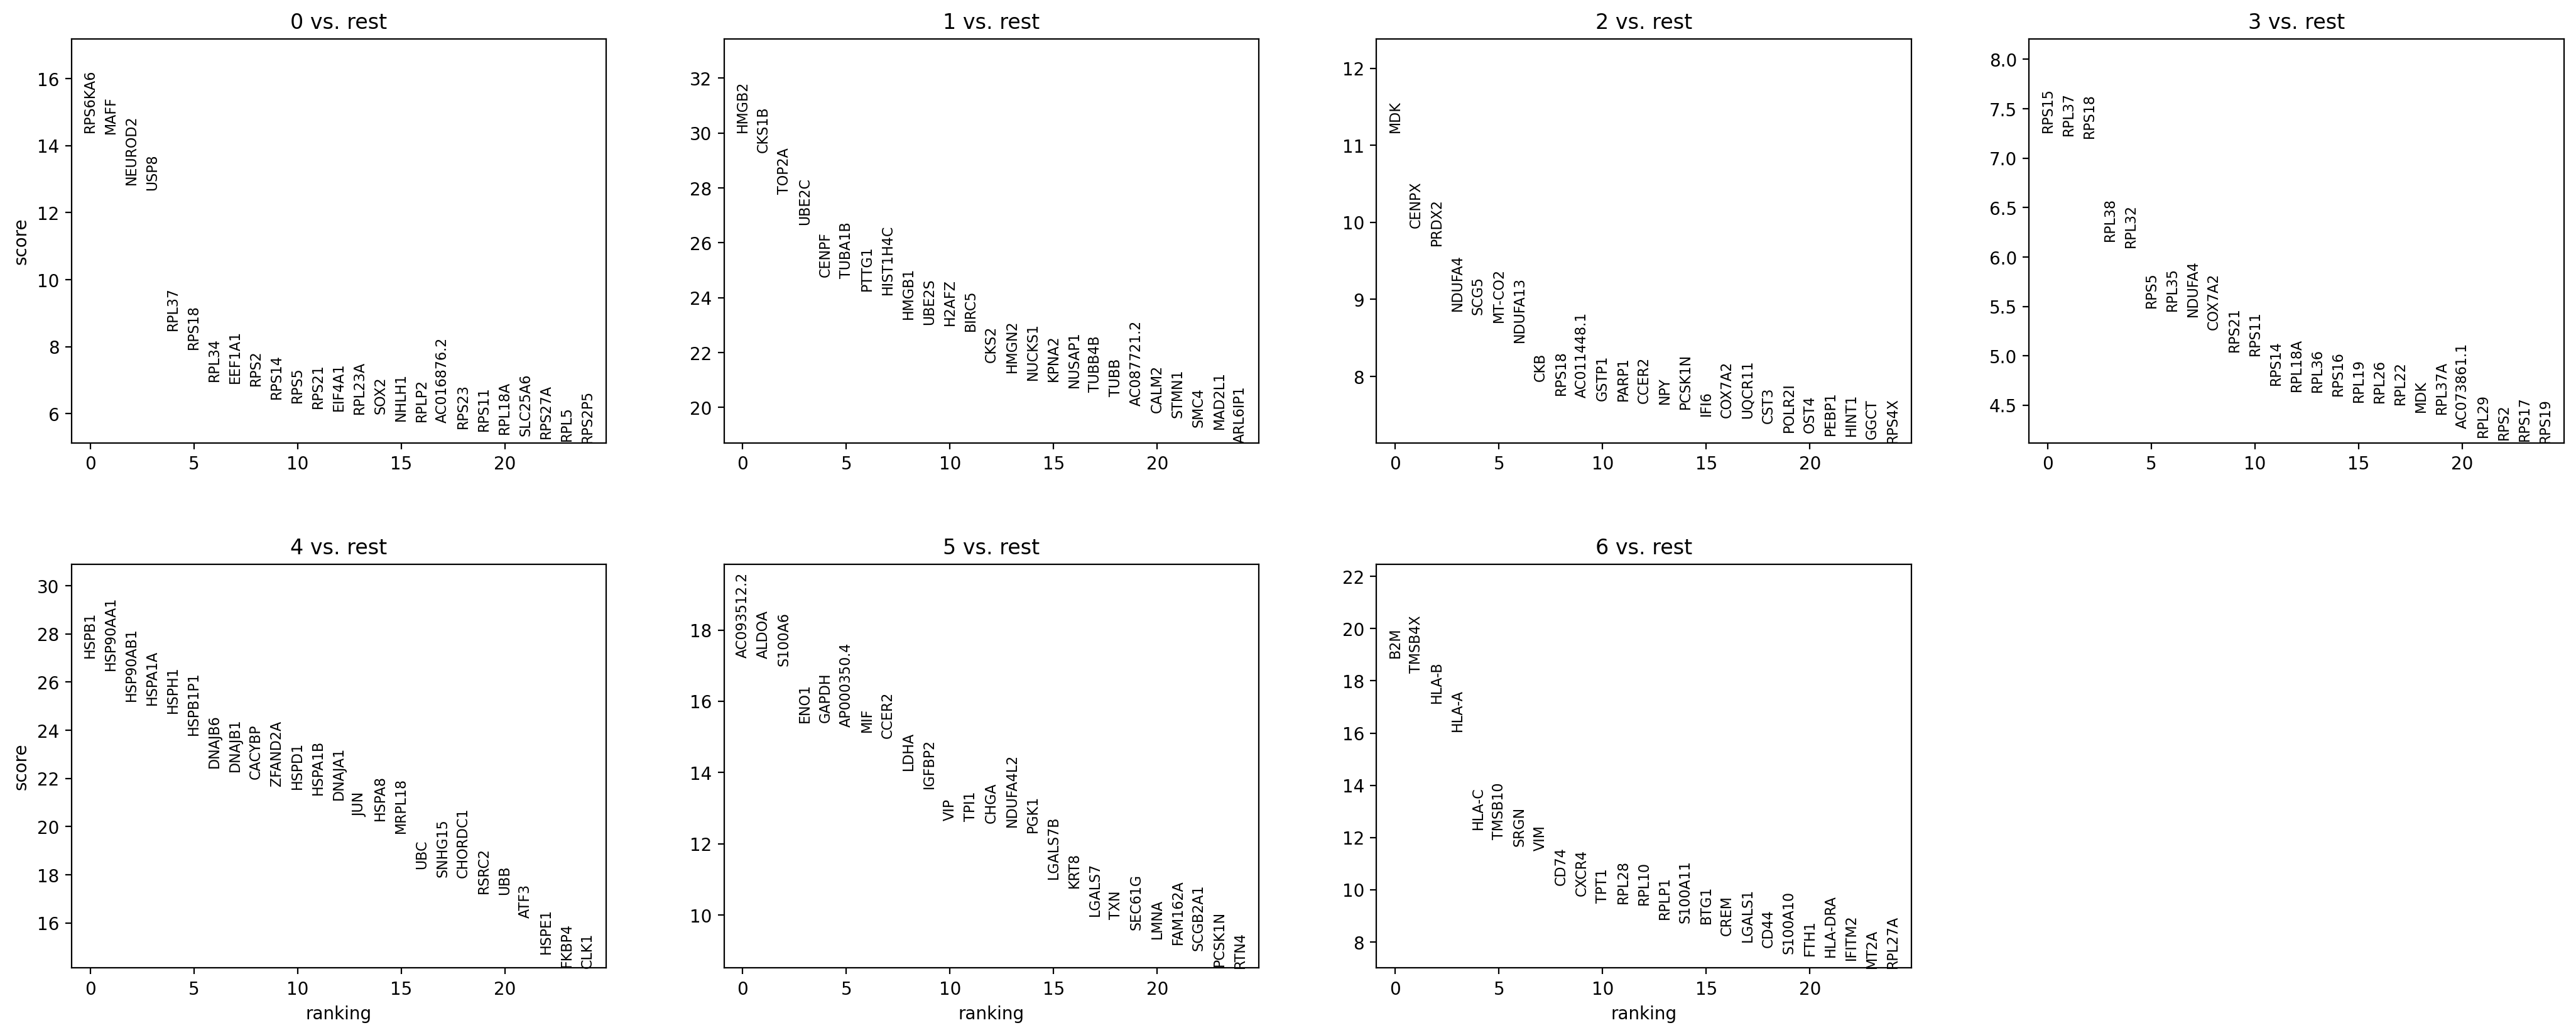

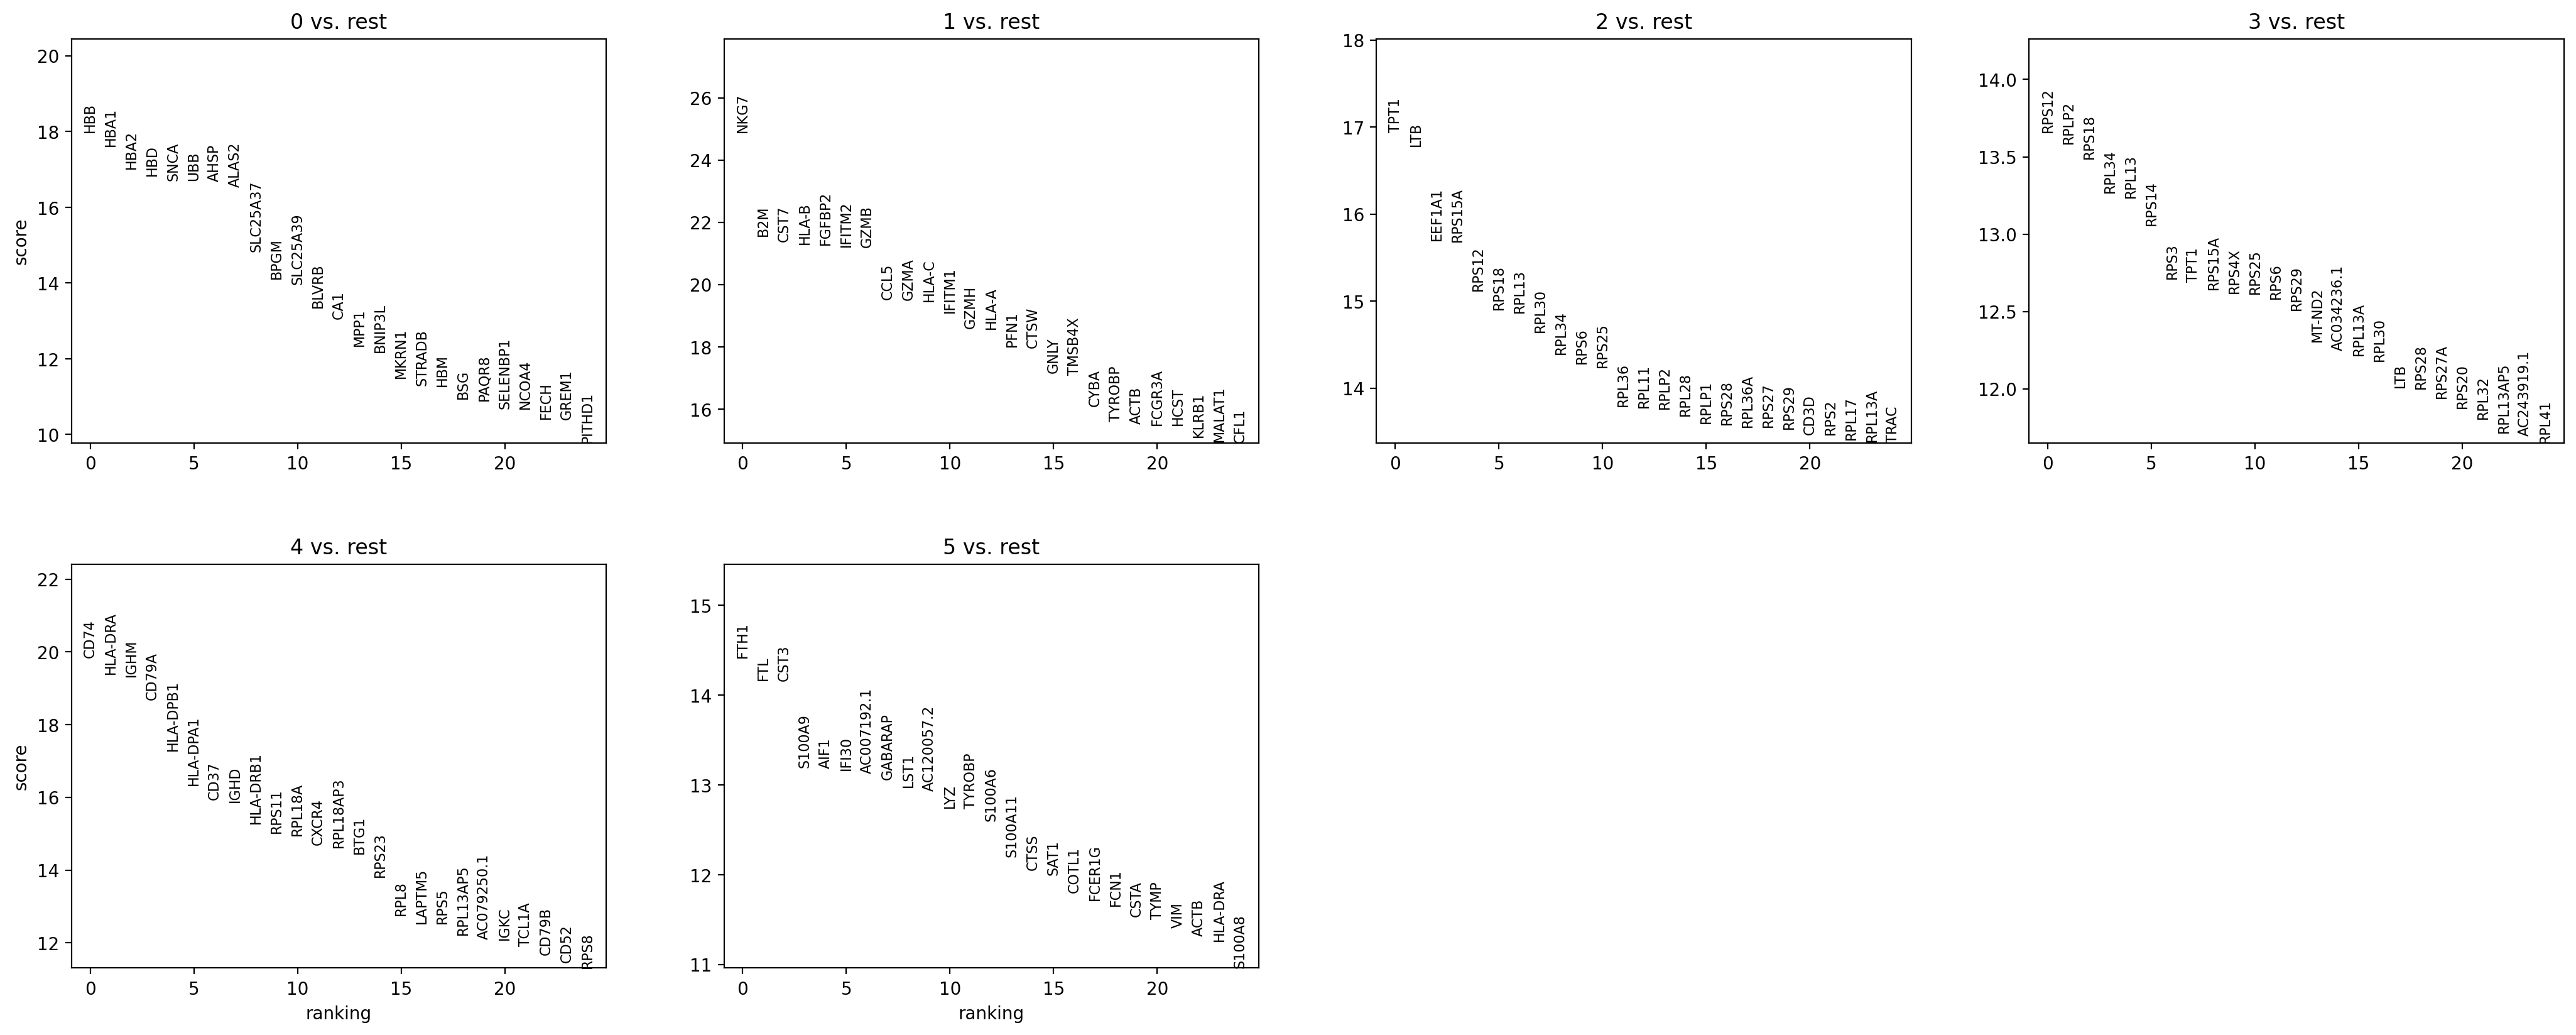

In [212]:
for adata, sp in zip(adatas, samples):
    sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, title=sp)

### Show top 10 ranked genes per cluster

In [219]:
samples

['SRR7722938', 'SRR7722942']

#### SRR7722938

In [221]:
pd.DataFrame(adatas[0].uns['rank_genes_groups']['names']).head(10)

0         1           2       3         4           5       6
0  RPS6KA6     HMGB2         MDK   RPS15     HSPB1  AC093512.2     B2M
1     MAFF     CKS1B       CENPX   RPL37  HSP90AA1       ALDOA  TMSB4X
2  NEUROD2     TOP2A       PRDX2   RPS18  HSP90AB1      S100A6   HLA-B
3     USP8     UBE2C      NDUFA4   RPL38    HSPA1A        ENO1   HLA-A
4    RPL37     CENPF        SCG5   RPL32     HSPH1       GAPDH   HLA-C
5    RPS18    TUBA1B      MT-CO2    RPS5   HSPB1P1  AP000350.4  TMSB10
6    RPL34     PTTG1     NDUFA13   RPL35    DNAJB6         MIF    SRGN
7   EEF1A1  HIST1H4C         CKB  NDUFA4    DNAJB1       CCER2     VIM
8     RPS2     HMGB1       RPS18  COX7A2    CACYBP        LDHA    CD74
9    RPS14     UBE2S  AC011448.1   RPS21   ZFAND2A      IGFBP2   CXCR4

### Check the tops genes in each cluster

In [229]:
marker_genes_1 = list(adatas[0].uns['rank_genes_groups']['names'][0])

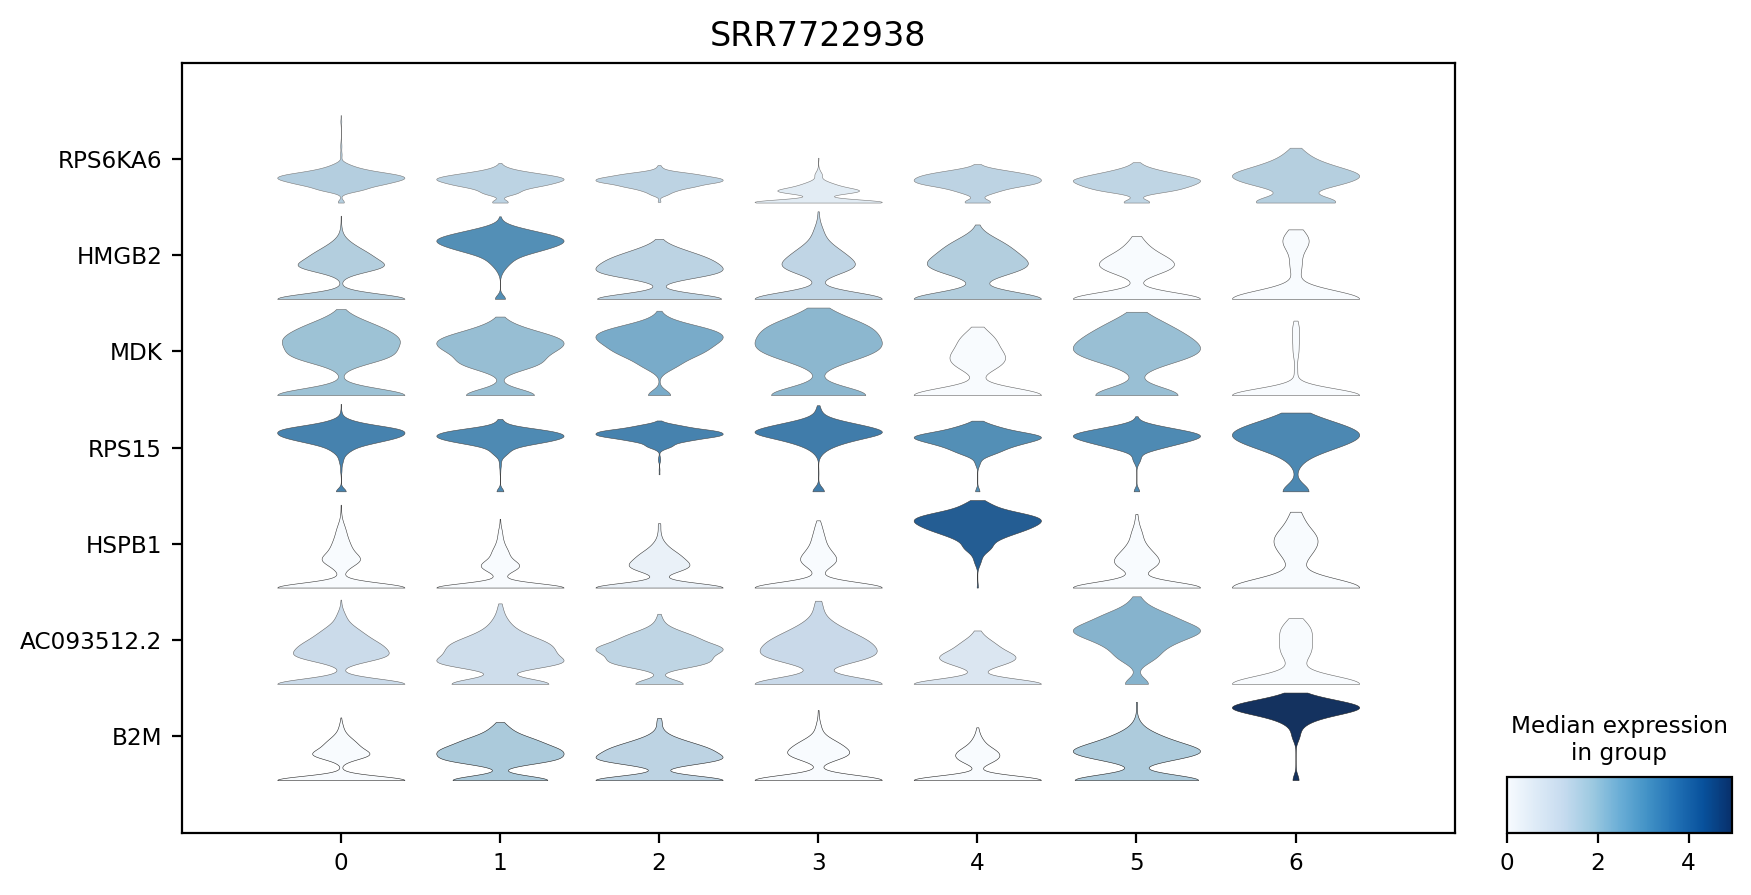

In [252]:
sc.pl.stacked_violin(adatas[0], 
                     marker_genes_1,
                     groupby='louvain',
                     rotation=90,
                     figsize=(10,5),
                     title=samples[0], 
                     swap_axes=True)

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is depr

ValueError: no field of name 7

<Figure size 640x480 with 0 Axes>

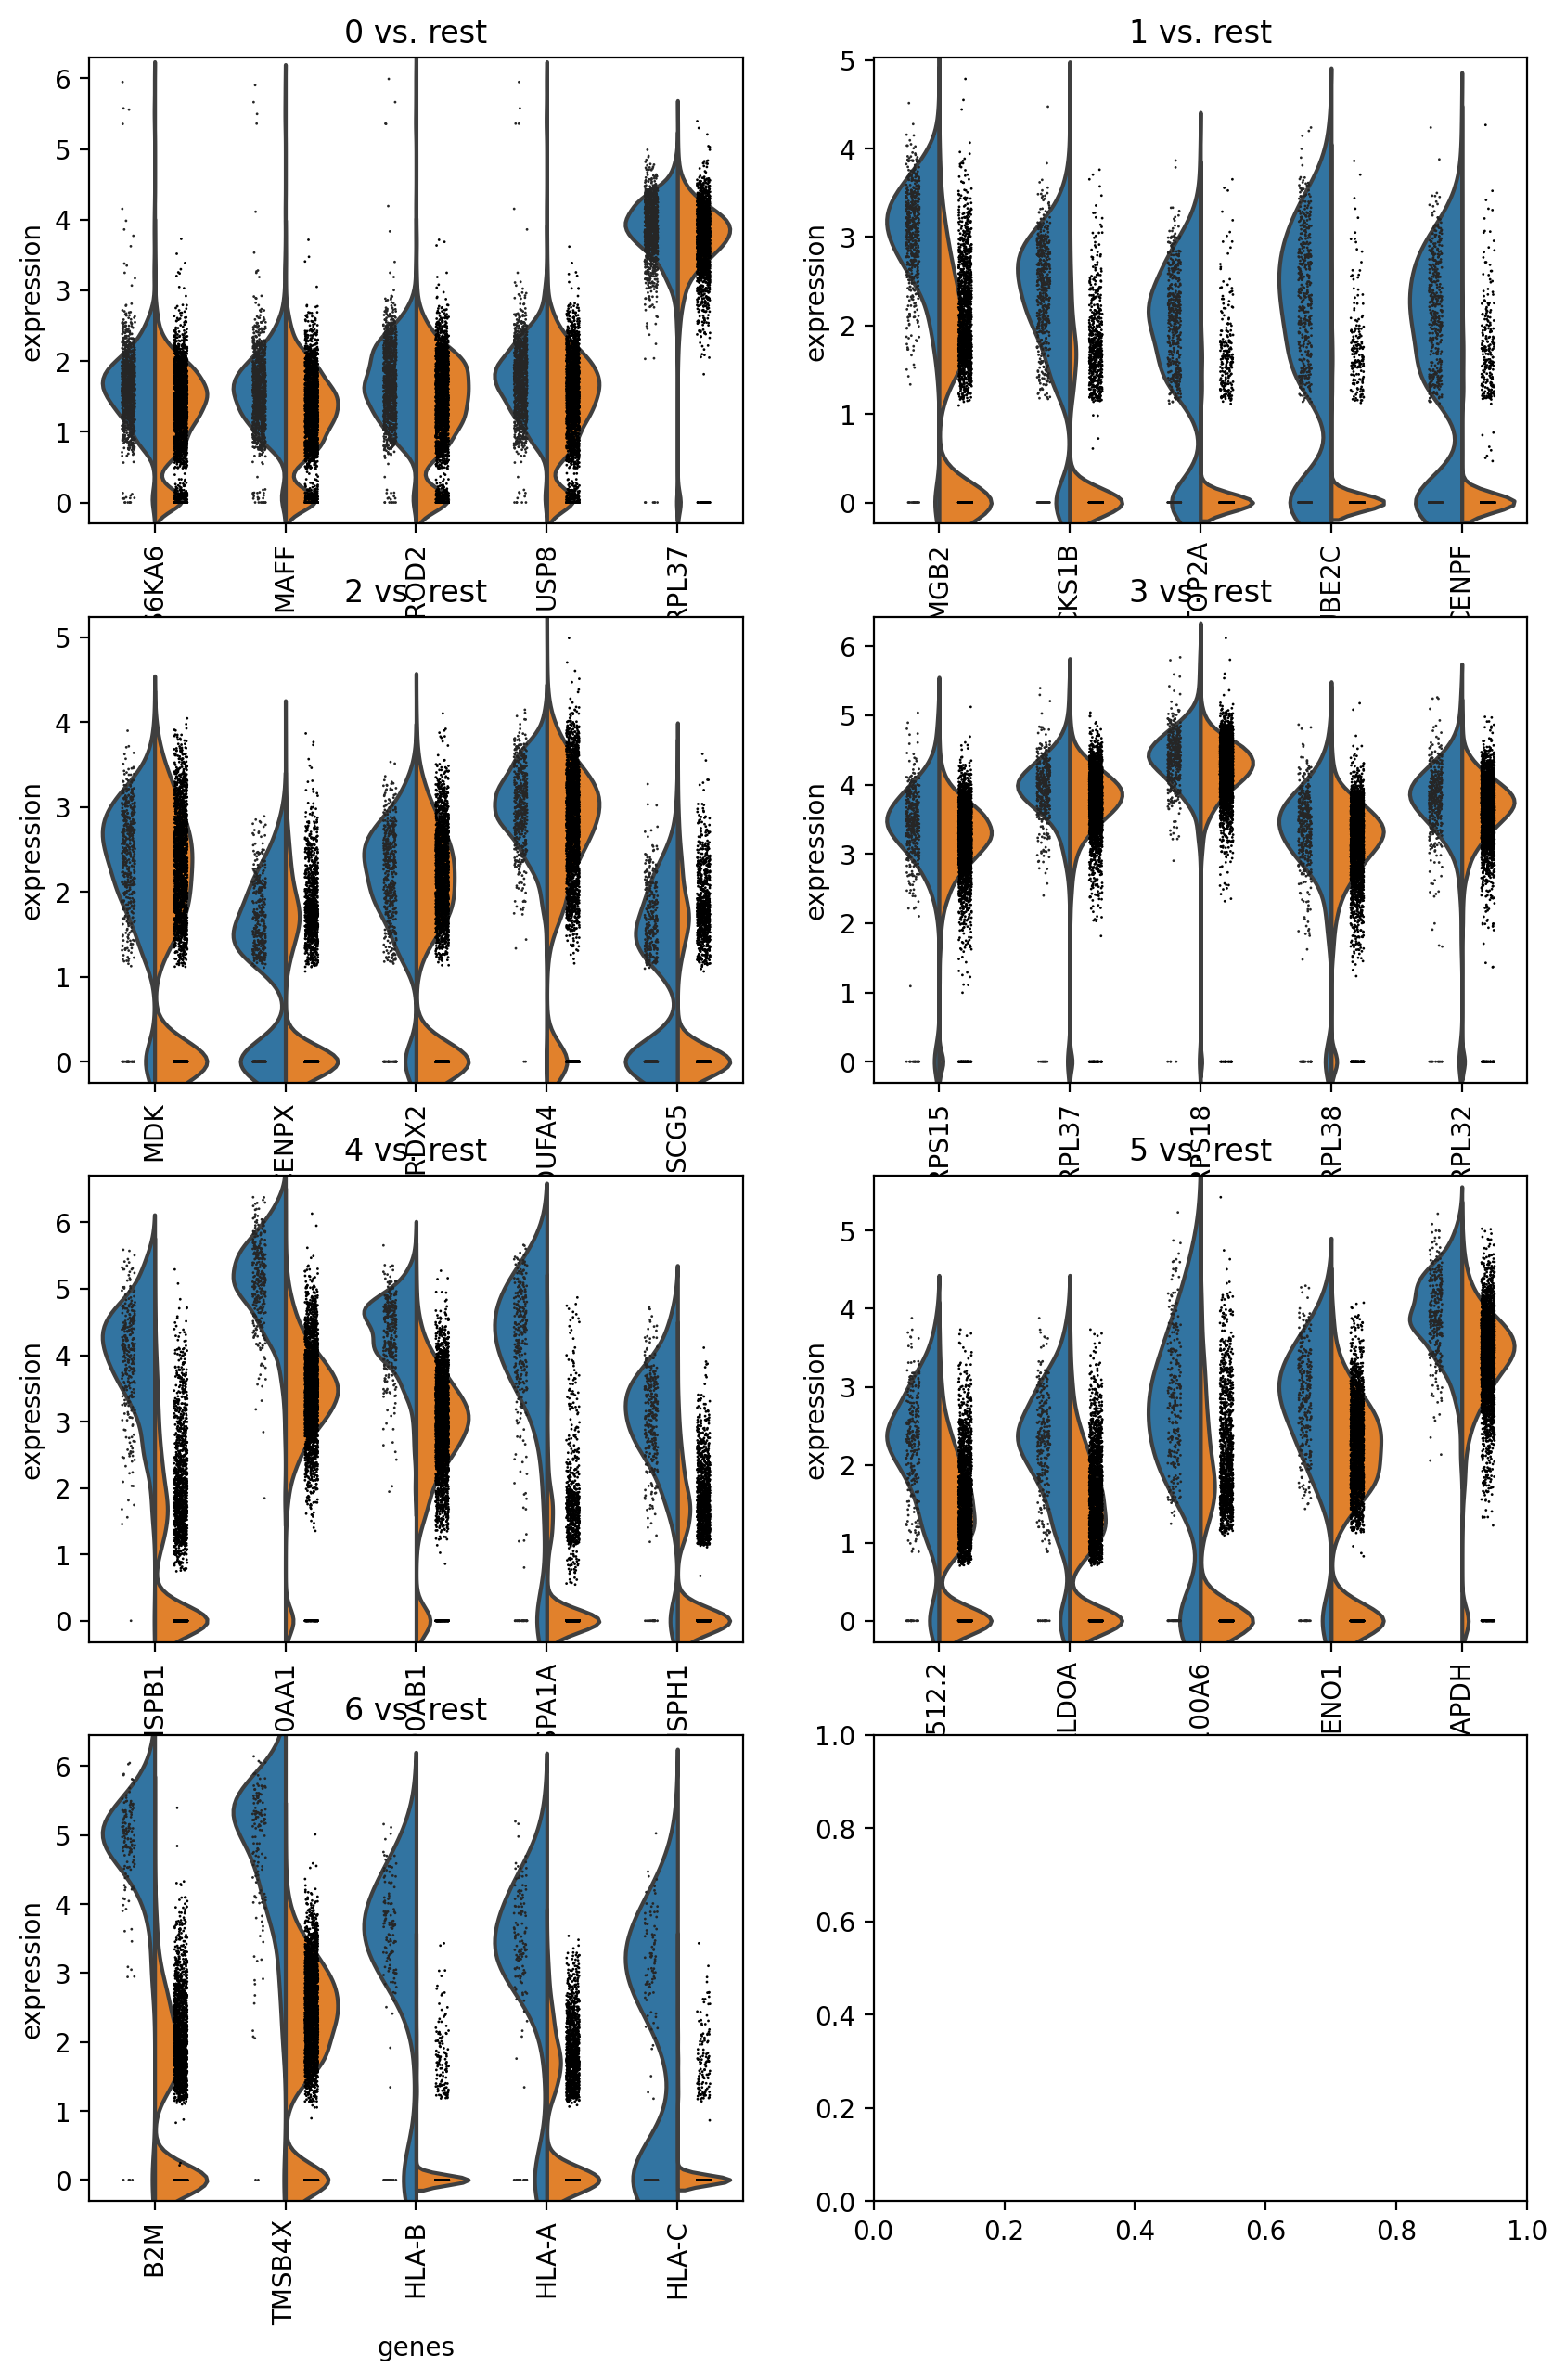

In [295]:
plt.tight_layout(pad = 3)
fig, axe = plt.subplots(4, 2, figsize=(10,15))
for idx, ((i, j), ax) in enumerate(np.ndenumerate(axe)):
    sc.pl.rank_genes_groups_violin(adatas[0], groups=str(idx), n_genes=5, ax=axe[i,j], show=False)

#### SRR7722942

In [222]:
pd.DataFrame(adatas[1].uns['rank_genes_groups']['names']).head(10)

0       1       2       3         4           5
0       HBB    NKG7    TPT1   RPS12      CD74        FTH1
1      HBA1     B2M     LTB   RPLP2   HLA-DRA         FTL
2      HBA2    CST7  EEF1A1   RPS18      IGHM        CST3
3       HBD   HLA-B  RPS15A   RPL34     CD79A      S100A9
4      SNCA  FGFBP2   RPS12   RPL13  HLA-DPB1        AIF1
5       UBB  IFITM2   RPS18   RPS14  HLA-DPA1       IFI30
6      AHSP    GZMB   RPL13    RPS3      CD37  AC007192.1
7     ALAS2    CCL5   RPL30    TPT1      IGHD     GABARAP
8  SLC25A37    GZMA   RPL34  RPS15A  HLA-DRB1        LST1
9      BPGM   HLA-C    RPS6   RPS4X     RPS11  AC120057.2

### Check the tops genes in each cluster

In [243]:
marker_genes_2 = list(adatas[1].uns['rank_genes_groups']['names'][0])

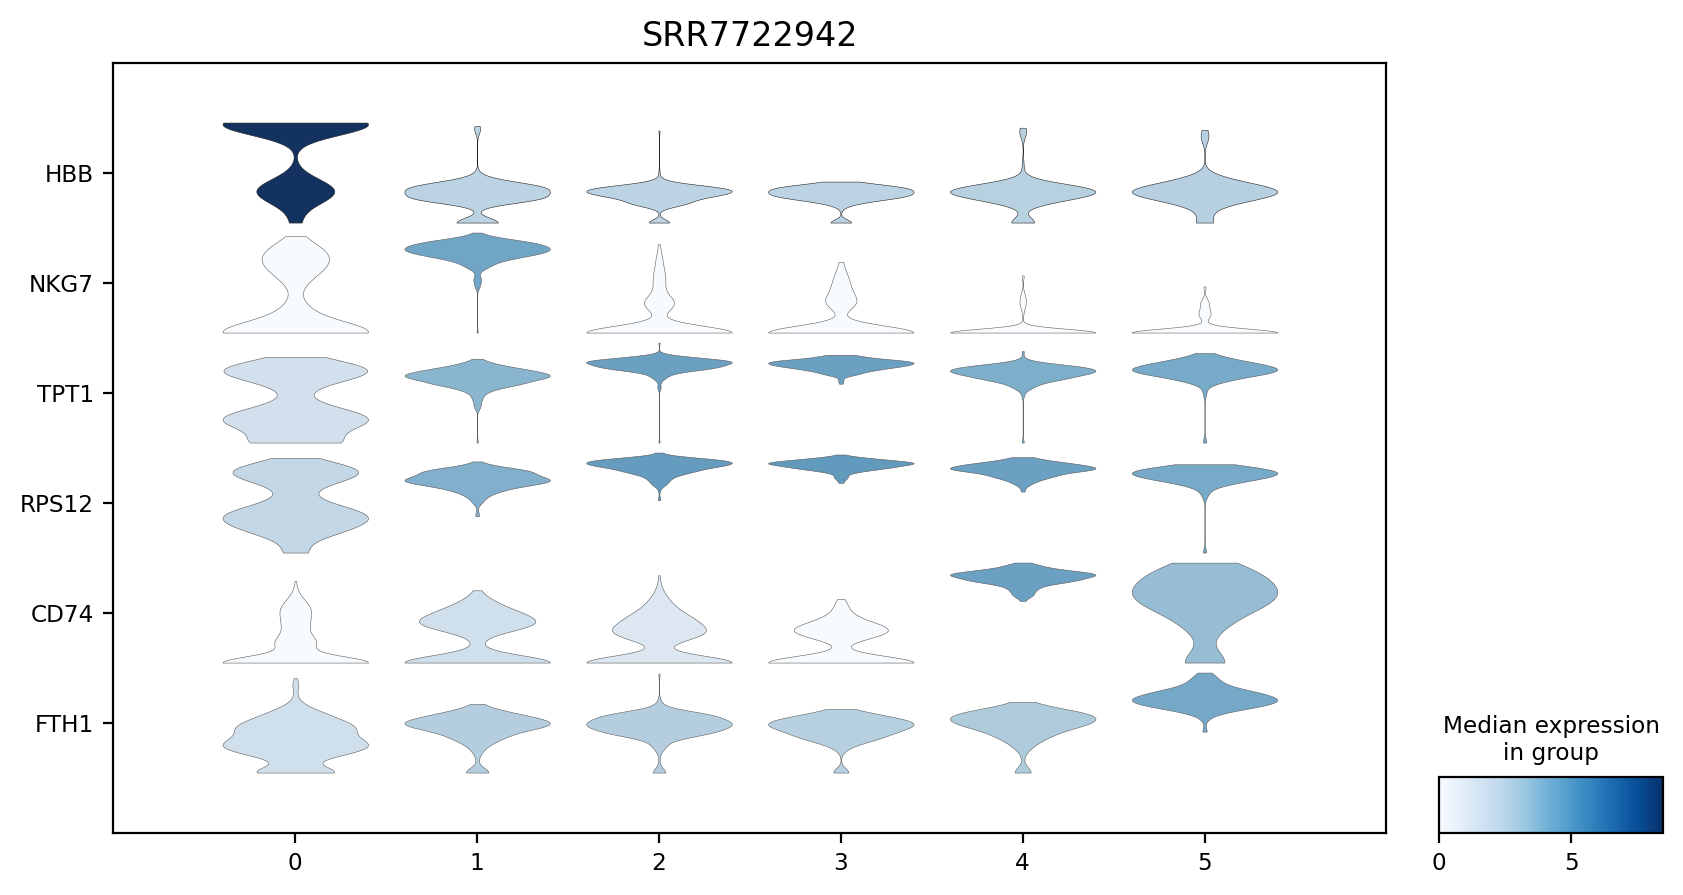

In [253]:
sc.pl.stacked_violin(adatas[1],
                     marker_genes_2,
                     groupby='louvain',
                     rotation=90,
                     figsize=(10,5),
                     title=samples[1],
                     swap_axes=True
                    )

## Expression of the top 10 marker genes in cells for each cluster

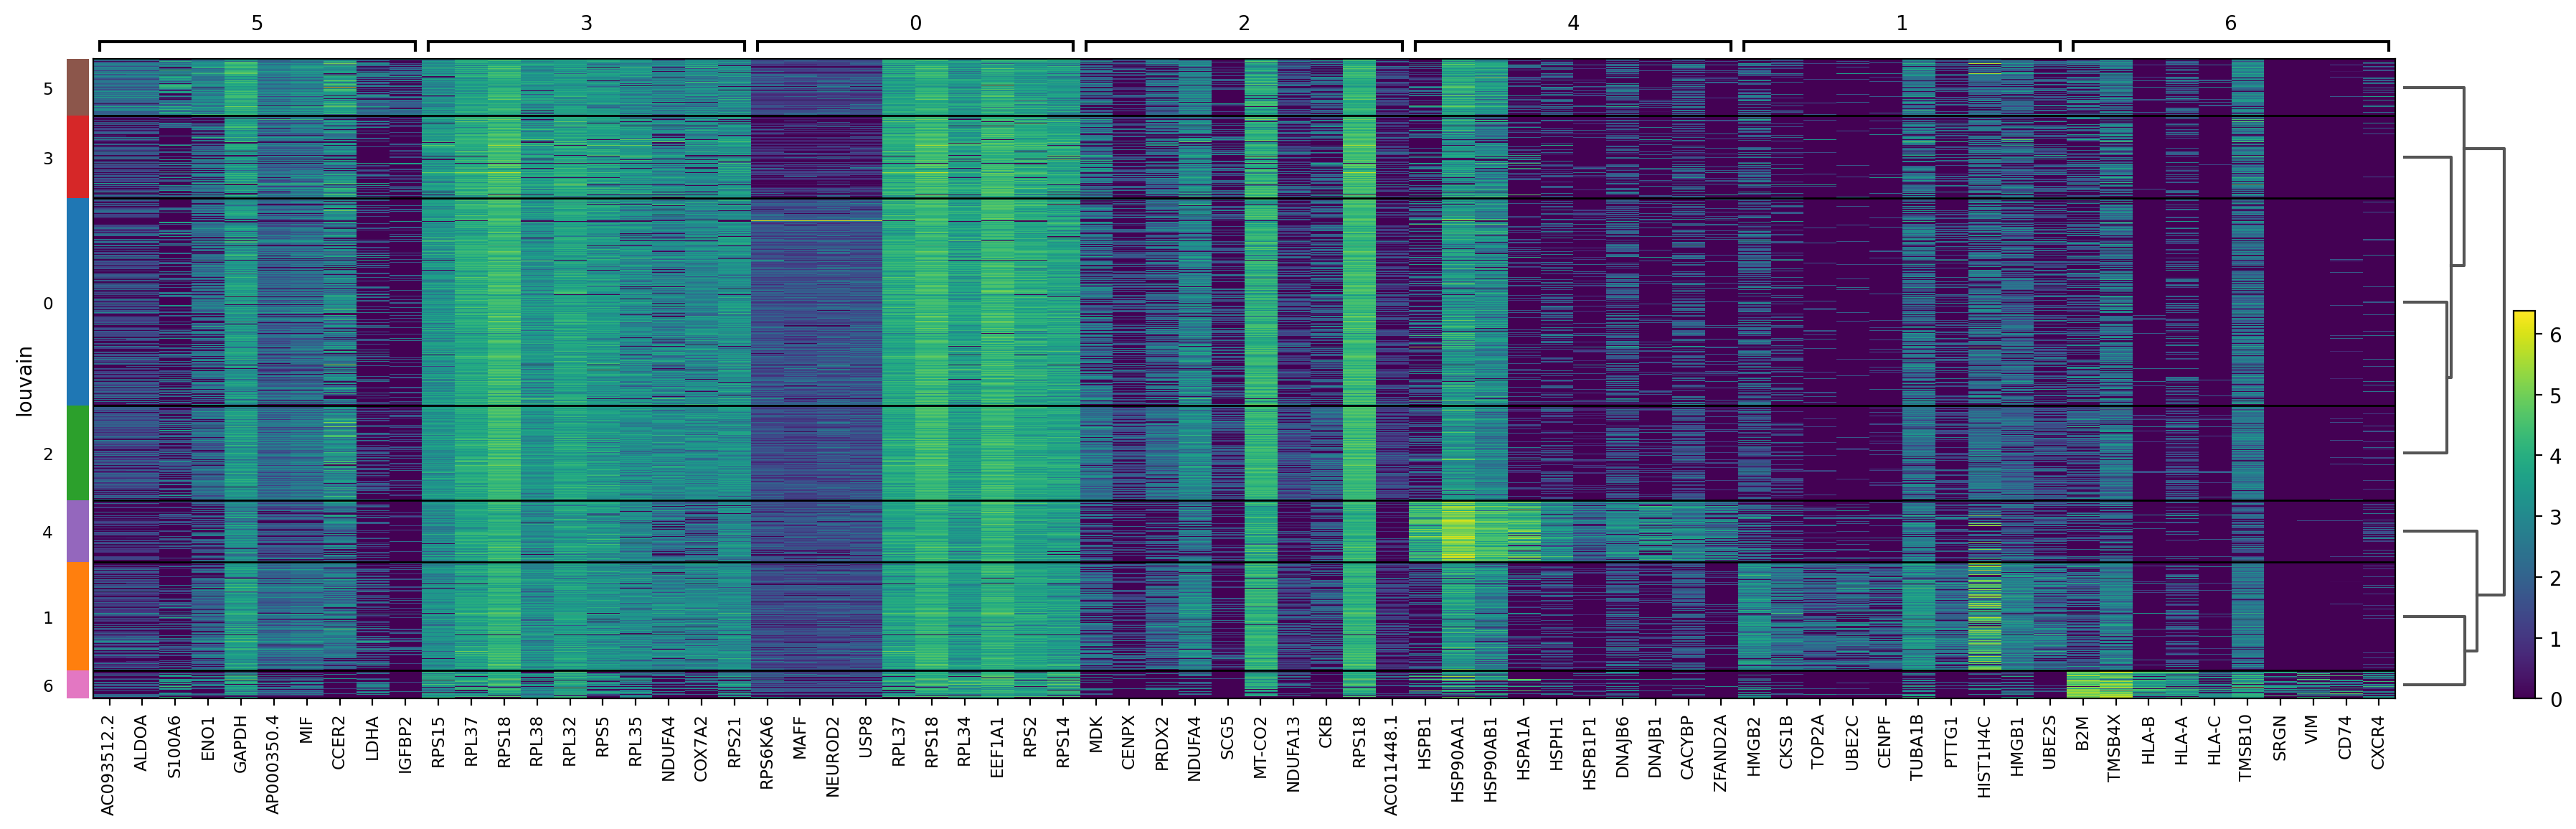

In [310]:
sc.pl.rank_genes_groups_heatmap(adatas[0], n_genes=10, groupby='louvain', key='rank_genes_groups', show_gene_labels=True)

In [329]:
for adata, sp in zip(adatas, samples):
    adata.raw.to_adata().write(f'/Users/liu.yak/Code/10x_sequence_analysis_pipeline/count_out_{sp}/counts_unfiltered/{sp}_mtx_only.h5ad')